# 1. Age Estimator

### 1.8 Model Variations

Preprocessing:

(a) Import libraries

(b) Load the saved training/validation/testing datasets

(c) Define a function to free up memory for GPU after model training

In [12]:
# (a) Import libraries
# --------------------------------------------------------------------
import tensorflow as tf                             # includes Keras and all its functionalities. It is used for building and training neural networks models such as CNNs.

# Enable GPU memory growth before importing other libraries
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)     # Prevent TensorFlow from allocating all GPU memory at once, avoiding out-of-memory errors (= crashes during training)

# Clear previous sessions to free up resources (before starting new model training) to avoid potential out-of-memory errors (= crashes during training)
tf.keras.backend.clear_session()

import gc                           # for garbage collection to free up memory

import matplotlib.pyplot as plt     # for creating visualizations in Python.
import pandas as pd                 # for data manipulation and analysis, particularly for working with DataFrames.  
import numpy as np                  # for numerical computing (e.g. arrays and  mathematical functions).
import os, pathlib                  # for interacting with the operating system and handling file paths.
import json                         # for working with JSON data (e.g. saving/loading training history).

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score             # for comparing models performances
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix                         # for evaluating classification models

import time                                     # for measuring training duration
from tensorflow.keras.models import load_model  # for loading saved Keras models

# from tensorflow import keras                      # not needed since tf includes keras
# from tensorflow.keras import layers, models       # not needed since tf includes keras
# --------------------------------------------------------------------

In [2]:
# (b) Load the saved training/validation/testing datasets
# --------------------------------------------------------------------

# training/validation/testing datasets for normalised images (Feature inputs: pixel values)
X_train_norm = np.load('X_train_norm.npy')              # scaled images between 0 and 1 
X_val_norm = np.load('X_val_norm.npy')
X_test_norm = np.load('X_test_norm.npy')

# training/validation/testing datasets for regression (Target features labels: age in years)
y_train_reg = np.load('y_train_reg.npy')                # converted from default int64 to float32
y_val_reg = np.load('y_val_reg.npy')
y_test_reg = np.load('y_test_reg.npy')

# training/validation/testing datasets for classification (Target features labels: age groups)
y_train_cls_ohe = np.load('y_train_cls_ohe.npy')        # transformed from integer labels to one-hot encoded format (2D arrays with binary values for each class)
y_val_cls_ohe = np.load('y_val_cls_ohe.npy')
y_test_cls_ohe = np.load('y_test_cls_ohe.npy')
# --------------------------------------------------------------------

# to reduce memory usage, convert X data splits to float16
X_train_norm = X_train_norm.astype('float16')
X_val_norm   = X_val_norm.astype('float16')
X_test_norm  = X_test_norm.astype('float16')

In [3]:
# (c) Define a function to free up memory for GPU after model training
# --------------------------------------------------------------------

# To avoid out-of-memory errors during hyperparameter tuning with multiple model trainings,
# we define a function to clear GPU memory after each model training.
def clear_gpu_memory():
    """Function to clear GPU memory after model training to avoid out-of-memory errors."""
    tf.keras.backend.clear_session()            # Clear Keras session
    gc.collect()                                # Run garbage collection (such as unused variables, tensors, etc., that are no longer needed and use GPU memory) 
# --------------------------------------------------------------------

Functions for variation models:

(d) Define 4 functions to create 4 sfuffled datasets for tuning (regression and classification)

(e) Define 2 functions to create 2 sfuffle datasets for final training and evaluation (regression and classification) 

(f) Define 2 functions to compile regression and classification models

(g) Define 2 functions to train regression and classification models with early stopping and save training history

(h) Define 2 functions to print the results of regression and classification models on test datasets

(i) Define 2 functions to plot the training history of regression and classification models

In [4]:
# (d) Define 4 functions to create 4 sfuffled datasets for tuning (regression and classification)
# --------------------------------------------------------------------

# training dataset is shuffled to improve generalization by exposing the model to different data orders each epoch; 
# it prevents the model from learning patterns in the order of the data.

# validation dataset is not shuffled as we want the same inputs in the same order every time during valuation; unlike the training set, the model does not update weights from validation data, 
# so shuffling is unnecessary

# .prefetch tells TensorFlow to prepare the next n batches in the background while the model is training on the current batch;
# prefetch(1) is usually enough for small dataset;
# prefetching more batches consumes more memory: keeping prefetch(1) is safest to avoid out-of-memory error using GPU.

def create_datasets_tuning_reg (X_train_norm, y_train_reg, X_val_norm, y_val_reg, batch_size):
    train_dataset_reg = tf.data.Dataset.from_tensor_slices((X_train_norm, y_train_reg))
    train_dataset_reg = train_dataset_reg.shuffle(buffer_size=1000).batch(batch_size).prefetch(1)     # shuffle training dataset to improve generalization  
    
    val_dataset_reg = tf.data.Dataset.from_tensor_slices((X_val_norm, y_val_reg))
    val_dataset_reg = val_dataset_reg.batch(batch_size)                                             # validation dataset is not shuffled as randomness is not desired during evaluation
    
    return train_dataset_reg, val_dataset_reg

def create_datasets_tuning_cls (X_train_norm, y_train_cls_ohe, X_val_norm, y_val_cls_ohe, batch_size):
    train_dataset_cls = tf.data.Dataset.from_tensor_slices((X_train_norm, y_train_cls_ohe))
    train_dataset_cls = train_dataset_cls.shuffle(buffer_size=1000).batch(batch_size).prefetch(1)
    
    val_dataset_cls = tf.data.Dataset.from_tensor_slices((X_val_norm, y_val_cls_ohe))
    val_dataset_cls = val_dataset_cls.batch(batch_size)                                                        
    
    return train_dataset_cls, val_dataset_cls

# --------------------------------------------------------------------
# (e) Define 2 functions to create 2 sfuffle datasets for final training and evaluation (regression and classification)
# --------------------------------------------------------------------
def create_datasets_final_reg (X_train_norm, y_train_reg, X_val_norm, y_val_reg, X_test_norm, y_test_reg, batch_size):
    train_dataset_reg = tf.data.Dataset.from_tensor_slices((X_train_norm, y_train_reg))
    train_dataset_reg = train_dataset_reg.shuffle(buffer_size=1000).batch(batch_size).prefetch(1)

    val_dataset_reg = tf.data.Dataset.from_tensor_slices((X_val_norm, y_val_reg))
    val_dataset_reg = val_dataset_reg.batch(batch_size)
    
    test_dataset_reg = tf.data.Dataset.from_tensor_slices((X_test_norm, y_test_reg))
    test_dataset_reg = test_dataset_reg.batch(batch_size)
    
    return train_dataset_reg, val_dataset_reg, test_dataset_reg

def create_datasets_final_cls (X_train_norm, y_train_cls_ohe, X_val_norm, y_val_cls_ohe, X_test_norm, y_test_cls_ohe, batch_size):
    train_dataset_cls = tf.data.Dataset.from_tensor_slices((X_train_norm, y_train_cls_ohe))
    train_dataset_cls = train_dataset_cls.shuffle(buffer_size=1000).batch(batch_size).prefetch(1)

    val_dataset_cls = tf.data.Dataset.from_tensor_slices((X_val_norm, y_val_cls_ohe))
    val_dataset_cls = val_dataset_cls.batch(batch_size)
    
    test_dataset_cls = tf.data.Dataset.from_tensor_slices((X_test_norm, y_test_cls_ohe))
    test_dataset_cls = test_dataset_cls.batch(batch_size)
    
    return train_dataset_cls, val_dataset_cls, test_dataset_cls

In [5]:
# (f) Define 2 functions to compile regression and classification models 
def compile_regression_model(model_name, optimizer_reg, best_learning_rate_reg):
    if optimizer_reg == 'adam':
        optimizer_final = tf.keras.optimizers.Adam(learning_rate=best_learning_rate_reg)
    else:
        optimizer_final = tf.keras.optimizers.SGD(learning_rate=best_learning_rate_reg)
    
    model_name.compile(
        optimizer=optimizer_final,
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model_name

def compile_classification_model(model_name, optimizer_cls, best_learning_rate_cls):
    if optimizer_cls == 'adam':
        optimizer_final = tf.keras.optimizers.Adam(learning_rate=best_learning_rate_cls)
    else:
        optimizer_final = tf.keras.optimizers.SGD(learning_rate=best_learning_rate_cls)
    
    model_name.compile(
        optimizer=optimizer_final,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model_name

In [ ]:
# (g) Define 2 functions to train regression and classification models with early stopping and save training history

def train_regression_model(model_name, train_dataset_reg, val_dataset_reg, best_num_epochs_reg, best_early_stopping_patience_reg, model_label):
    early_stopping = tf.keras.callbacks.EarlyStopping(  # callback to stop training when validation performance stops improving
        monitor='val_loss',                             # monitor validation loss to determine when to stop training
        patience=best_early_stopping_patience_reg,      # number of epochs with no improvement after which training will be stopped
        restore_best_weights=True       # Restore the best weights when early stopping is triggered (preventing model from continuing to train on noise after performance stops improving)
    )
    history = model_name.fit(
        train_dataset_reg,                  # training dataset used for model training
        validation_data=val_dataset_reg,    # validation dataset used to evaluate the model's performance after each epoch
        epochs=best_num_epochs_reg,         # total number of epochs to train the model
        callbacks=[early_stopping]          # uses early stopping settings (e.g., patience) to stop training when validation performance stops improving, helping prevent overfitting
    )
    # Save training history
    history_file = f"history_{model_label}_regression.json"
    with open(history_file, "w") as f:
        json.dump(history.history, f)
    
    return history


def train_classification_model(model_name, train_dataset_cls, val_dataset_cls, best_num_epochs_cls, best_early_stopping_patience_cls, model_label):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=best_early_stopping_patience_cls,
        restore_best_weights=True
    )
    history = model_name.fit(
        train_dataset_cls,
        validation_data=val_dataset_cls,
        epochs=best_num_epochs_cls,
        callbacks=[early_stopping]
    )
    
    # Save training history
    history_file = f"history_{model_label}_classification.json"
    with open(history_file, "w") as f:
        json.dump(history.history, f)
    
    return history

In [ ]:
# (h) Define 2 functions to print the results and save the models

def report_and_save_regression_model(model_name, model_label,
                                     test_loss, test_mae):
    """
    Prints regression model summary and test results,
    then saves the model using model_label to name the file.

    Parameters:
        model_name: Keras model object
        model_label: short name to be used in the filename
        test_loss: float (MSE)
        test_mae: float
    """

    print(f"\n===== Regression Model Summary ({model_label}) =====")
    model_name.summary()

    print(f"\n===== Final Test Results (Regression - {model_label}) =====")
    print(f"Test Loss (MSE): {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    save_path = f"final_base_cnn_{model_label}_regression.keras"
    model_name.save(save_path)
    print(f"Model saved to: {save_path}\n")

def report_and_save_classification_model(model_name, model_label,
                                         test_loss, test_accuracy):
    """
    Prints classification model summary and test results,
    then saves the model using model_label to name the file.

    Parameters:
        model_name: Keras model object
        model_label: short name to be used in the filename
        test_loss: float
        test_accuracy: float
    """

    print(f"\n===== Classification Model Summary ({model_label}) =====")
    model_name.summary()

    print(f"\n===== Final Test Results (Classification - {model_label}) =====")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    save_path = f"final_base_cnn_{model_label}_classification.keras"
    model_name.save(save_path)
    print(f"Model saved to: {save_path}\n")

In [8]:
# (i) Define 2 functions to plot the training history of regression and classification models

def plot_regression_history(history_file, title=None):
    
     with open(history_file, "r") as f:
          history = json.load(f)
     
     plt.figure(figsize=(10, 6))
     plt.plot(history['mean_absolute_error'], label='Training MAE')
     plt.plot(history['val_mean_absolute_error'], label='Validation MAE')
     plt.xlabel('Epochs')
     plt.ylabel('Mean Absolute Error (MAE)')
     if title:
          plt.title(title)
     else:
          plt.title('Regression Model Training History')
     plt.legend()
     plt.grid()
     plt.show()

def plot_classification_history(history_file, title=None):
     
     with open(history_file, "r") as f:
          history = json.load(f)
     
     plt.figure(figsize=(10, 6))
     plt.plot(history['accuracy'], label='Training Accuracy')
     plt.plot(history['val_accuracy'], label='Validation Accuracy')
     plt.xlabel('Epochs')
     plt.ylabel('Accuracy')
     if title:
          plt.title(title)
     else:
          plt.title('Classification Model Training History')
     plt.legend()
     plt.grid()
     plt.show()

Baseline models:

(l) Define CNN building functions to create final baseline models for Regression and Classification (without variations)

(m) Define best hyperparameters from previous tuning for final baseline model training and evaluation

In [9]:
# (l) Define CNN building functions to create final baseline models for Regression and Classification

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
# Batach Normalization normalizes the activations of the previous layer at each batch,)
# i.e., applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
# This helps stabilize and speed up the training process by reducing internal covariate shift.

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
# Dropout is a regularization technique that randomly sets a fraction of input units to 0 at each update during training time,
# which helps prevent overfitting by reducing reliance on specific neurons.

# --- REGRESSION MODEL ---
def final_build_base_cnn_reg(input_shape=(128, 128, 3), dropout_rate=None):
    """
    Improved CNN for final regression model.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128, activation='relu'),      # Fully connected layer with 128 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(1)                            # Regression output
    ]
    
    return tf.keras.Sequential(layers)

# --- CLASSIFICATION MODEL ---
def final_build_base_cnn_cls(input_shape=(128, 128, 3), dropout_rate=None, num_classes=y_test_cls_ohe.shape[1]):
    """
    Improved CNN for final classification model.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                               input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128, activation='relu'),      # Fully connected layer with 128 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')    # Classification output
    ]
    
    return tf.keras.Sequential(layers)



In [10]:
# (m) Define best hyperparameters from previous tuning for final model training and evaluation
# --------------------------------------------------------------------

# Previous best results from learning rate and batch size tuning for regression and classification
best_learning_rate_reg = 0.0005
best_batch_size_reg = 32
best_learning_rate_cls = 0.0005
best_batch_size_cls = 32
best_early_stopping_patience_reg = 8
best_early_stopping_patience_cls = 8
best_num_epochs_reg = 80
best_num_epochs_cls = 80
optimizer_reg = 'adam'       
optimizer_cls = 'adam'
best_dropout_rate_reg = 0.3
best_dropout_rate_cls = 0.5

Models comparison:

(n) Define a function to append the model results to a results list for regression and classification

In [11]:
# (n) Define a function to append the model results to a results list for regression and classification

regression_results = []  # Initialize a global results list for regression
classification_results = []  # Initialize a global results list for classification

# Load the saved regression model, report test results and append to results list
def append_regression_results_from_saved(model_label, model_file, test_dataset, note=None):
    """
    Reload a saved regression model, evaluate on test set, and append results to `results`.
    
    Parameters:
        model_label (str): Name/label of the model
        model_file (str): Path to saved .keras model
        test_dataset: tf.data.Dataset for test data
    """
    # Clear GPU memory before loading the model
    clear_gpu_memory()
    
    # Reload the saved model
    model = load_model(model_file)
    
    # Evaluate on test set
    test_loss, test_mae = model.evaluate(test_dataset, verbose=0)
    
    # Get model parameters
    params = model.count_params()
    
    # Append results
    regression_results.append({
        "Model": model_label,
        "Test_Loss_MSE": test_loss,
        "Test_MAE": test_mae,
        "Parameters": params,
        "Note": note
    })
    # Clear GPU memory after appending results
    clear_gpu_memory()

# Load the saved classification model, report test results and append to results list
def append_classification_results_from_saved(model_label, model_file, test_dataset, note=None):
    """
    Reload a saved classification model, evaluate on test set, and append results to `results`.
    
    Parameters:
        model_label (str): Name/label of the model
        model_file (str): Path to saved .keras model
        test_dataset: tf.data.Dataset for test data
    """
    # Clear GPU memory before loading the model
    clear_gpu_memory()
    
    # Reload the saved model
    model = load_model(model_file)
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
    
    # Get model parameters
    params = model.count_params()
    
    # Append results
    classification_results.append({
        "Model": model_label,
        "Test_Loss": test_loss,
        "Test_Accuracy": test_accuracy,
        "Parameters": params,
        "Note": note
    })
    # Clear GPU memory after appending results
    clear_gpu_memory()

#### 1.8.1 CNN Kernel Variations

##### 1.8.1.1 Different activation functions

In [12]:
# (a) Decide what activation functions for the models to train and evaluate
# --------------------------------------------------------------------
# Different activations functions can be used in the hidden layers of a CNN, such as ReLU, Leaky ReLU, ELU, and SELU. 
# Each has its own advantages and disadvantages in terms of convergence speed, handling of negative inputs, and computational efficiency. 
# The choice of activation function can significantly impact the model's performance and training dynamics.

# https://www.geeksforgeeks.org/deep-learning/activation-function-in-tensorflow/

# We will consider the following activation functions:
# 1. ReLU: baseline activation previously used in all earlier models - it won't be used here
#       Advantages: fast, standard, works well on images; 
#           computationally efficient, helps mitigate vanishing gradient problem (the gradient becomes too small for effective learning in deep networks).
# 2. Leaky ReLU: it helps prevent the “dying ReLU” problem and can improve feature extraction in face images that contain shadows 
#               or low-intensity regions (where many pixels are dark or zero, common in face datasets))
#       Advantages: allows a small gradient when the unit is not active, helping to avoid dying ReLU problem; 
#               minimal parameter changes; officially recommended for CNNs.
# 3. ELU: it provides smoother negative outputs and can improve convergence speed and stability, especially useful for age regression tasks on real-world facial images.
#       Advantages: smooths the output for negative inputs, which can lead to faster convergence (reaching optimal weights during training);
#               often improves performance on deep CNNs; a notable improvement over ReLU when training from scratch.

# These two activation functions (Leaky ReLU and ELU) are commonly used as practical alternatives to ReLU for CNNs trained from scratch on image datasets. 
# They offer a balance between computational efficiency and improved representational power, making them well suited for this dataset.


In [12]:
# (b) Define 4 functions to create CNN models with different activation functions for regression and classification
# ----------------------------------------------------

# Leaky ReLU activation function REGRESSION
def final_build_variation_cnn_LeakyReLU_reg (input_shape=(128, 128, 3), dropout_rate=None, activation_function='leaky_relu'):
    """
    Improved CNN for final regression model with Leaky ReLU activation.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        tf.keras.layers.LeakyReLU(),                        # Leaky ReLU activation
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.LeakyReLU(),                        # Leaky ReLU activation
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128),                         # Fully connected layer with 128 neurons    
        tf.keras.layers.LeakyReLU(),                        # Leaky ReLU activation
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(1)                            # Regression output
    ]
    
    return tf.keras.Sequential(layers)

# ELU activation function REGRESSION
def final_build_variation_cnn_ELU_reg (input_shape=(128, 128, 3), dropout_rate=None, activation_function='elu'):
    """
    Improved CNN for final regression model with ELU activation.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        tf.keras.layers.ELU(),                              # ELU activation
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.ELU(),                              # ELU activation
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128),                         # Fully connected layer with 128 neurons    
        tf.keras.layers.ELU(),                              # ELU activation
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(1)                            # Regression output
    ]
    
    return tf.keras.Sequential(layers)


# Leaky ReLU activation function CLASSIFICATION
def final_build_variation_cnn_LeakyReLU_cls (input_shape=(128, 128, 3), dropout_rate=None, num_classes=y_test_cls_ohe.shape[1]):
    """
    Improved CNN for final classification model with Leaky ReLU activation.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        tf.keras.layers.LeakyReLU(),                        # Leaky ReLU activation
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.LeakyReLU(),                        # Leaky ReLU activation
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128),                         # Fully connected layer with 128 neurons    
        tf.keras.layers.LeakyReLU(),                        # Leaky ReLU activation
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')    # Classification output
    ]
    
    return tf.keras.Sequential(layers)

# ELU activation function CLASSIFICATION
def final_build_variation_cnn_ELU_cls (input_shape=(128, 128, 3), dropout_rate=None, num_classes=y_test_cls_ohe.shape[1]):
    """
    Improved CNN for final classification model with ELU activation.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        tf.keras.layers.ELU(),                              # ELU activation
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.ELU(),                              # ELU activation
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128),                         # Fully connected layer with 128 neurons    
        tf.keras.layers.ELU(),                              # ELU activation
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')    # Classification output
    ]
    
    return tf.keras.Sequential(layers)



In [ ]:
# (c) Final models training and evaluation with best hyperparameters
# --------------------------------------------------------------------

# 1. Leaky ReLU activation function for REGRESSION MODEL

print ("Training Leaky ReLU Regression Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (training + validation + test) to reduce memory usage with the function
train_dataset_reg, val_dataset_reg, test_dataset_reg = create_datasets_final_reg(X_train_norm, y_train_reg, X_val_norm, y_val_reg, X_test_norm, y_test_reg, best_batch_size_reg)

# Build (with the function) and compile regression model
model_LeakyReLU_reg = final_build_variation_cnn_LeakyReLU_reg(dropout_rate=best_dropout_rate_reg)

# Compile regression model
model_LeakyReLU_reg = compile_regression_model(model_LeakyReLU_reg, optimizer_reg, best_learning_rate_reg)

# Train regression model
history_reg = train_regression_model(model_LeakyReLU_reg, train_dataset_reg, val_dataset_reg, best_num_epochs_reg, best_early_stopping_patience_reg, 'LeakyReLU')

# Evaluate regression model on test set
test_loss_LeakyReLU_reg, test_mae_LeakyReLU_reg = model_LeakyReLU_reg.evaluate(test_dataset_reg)          # .evaluate method computes the loss and metrics on the test dataset

# Clear previous models and free up memory
clear_gpu_memory()


# 2. ELU activation function for REGRESSION MODEL

print ("Training ELU Regression Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (training + validation + test) to reduce memory usage with the function
train_dataset_reg, val_dataset_reg, test_dataset_reg = create_datasets_final_reg(X_train_norm, y_train_reg, X_val_norm, y_val_reg, X_test_norm, y_test_reg, best_batch_size_reg)

# Build (with the function) and compile regression model
model_ELU_reg = final_build_variation_cnn_ELU_reg(dropout_rate=best_dropout_rate_reg)

# Compile regression model
model_ELU_reg = compile_regression_model(model_ELU_reg, optimizer_reg, best_learning_rate_reg)

# Train regression model
history_reg = train_regression_model(model_ELU_reg, train_dataset_reg, val_dataset_reg, best_num_epochs_reg, best_early_stopping_patience_reg, 'ELU')

# Evaluate regression model on test set
test_loss_ELU_reg, test_mae_ELU_reg = model_ELU_reg.evaluate(test_dataset_reg)          # .evaluate method computes the loss and metrics on the test dataset

# Clear previous models and free up memory
clear_gpu_memory()


# 3. Leaky ReLU activation function for CLASSIFICATION MODEL

print ("Training Leaky ReLU Classification Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (for training + validation, test) to reduce memory usage with the function
train_dataset_cls, val_dataset_cls, test_dataset_cls = create_datasets_final_cls(X_train_norm, y_train_cls_ohe, X_val_norm, y_val_cls_ohe, X_test_norm, y_test_cls_ohe, best_batch_size_cls)

# Build (using the function) and compile classification model
model_LeakyReLU_cls = final_build_variation_cnn_LeakyReLU_cls(dropout_rate=best_dropout_rate_cls)

# Compile classification model
model_LeakyReLU_cls = compile_classification_model(model_LeakyReLU_cls, optimizer_cls, best_learning_rate_cls)

# Train classification model
history_cls = train_classification_model(model_LeakyReLU_cls, train_dataset_cls, val_dataset_cls, best_num_epochs_cls, best_early_stopping_patience_cls, 'LeakyReLU')

# Evaluate classification model on test set
test_loss_LeakyReLU_cls, test_accuracy_LeakyReLU_cls = model_LeakyReLU_cls.evaluate(test_dataset_cls)

# Clear previous models and free up memory
clear_gpu_memory()


# 4. ELU activation function for CLASSIFICATION MODEL

print ("Training ELU Classification Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (for training + validation, test) to reduce memory usage with the function
train_dataset_cls, val_dataset_cls, test_dataset_cls = create_datasets_final_cls(X_train_norm, y_train_cls_ohe, X_val_norm, y_val_cls_ohe, X_test_norm, y_test_cls_ohe, best_batch_size_cls)

# Build (using the function) and compile classification model
model_ELU_cls = final_build_variation_cnn_ELU_cls(dropout_rate=best_dropout_rate_cls)

# Compile classification model
model_ELU_cls = compile_classification_model(model_ELU_cls, optimizer_cls, best_learning_rate_cls)

# Train classification model
history_cls = train_classification_model(model_ELU_cls, train_dataset_cls, val_dataset_cls, best_num_epochs_cls, best_early_stopping_patience_cls, 'ELU')

# Evaluate classification model on test set
test_loss_ELU_cls, test_accuracy_ELU_cls = model_ELU_cls.evaluate(test_dataset_cls)

# Clear previous models and free up memory
clear_gpu_memory()


# Display final test results and save final models
report_and_save_regression_model(model_LeakyReLU_reg, 'LeakyReLU', test_loss_LeakyReLU_reg, test_mae_LeakyReLU_reg)
report_and_save_regression_model(model_ELU_reg, 'ELU', test_loss_ELU_reg, test_mae_ELU_reg)
report_and_save_classification_model(model_LeakyReLU_cls, 'LeakyReLU', test_loss_LeakyReLU_cls, test_accuracy_LeakyReLU_cls)
report_and_save_classification_model(model_ELU_cls, 'ELU', test_loss_ELU_cls, test_accuracy_ELU_cls)

Final Test Results for different activation functions:
- (Regression - LeakyReLU) // Test Loss (MSE): 259.9274  //  Test MAE: 13.0698
- (Regression - ELU)  //  Test Loss (MSE): 308.5804  //  Test MAE: 14.2884
- (Classification - LeakyReLU) //  Test Loss: 1.1679  //  Test Accuracy: 0.5791
- (Classification - ELU)  //  Test Loss: 1.3038  //  Test Accuracy: 0.4743

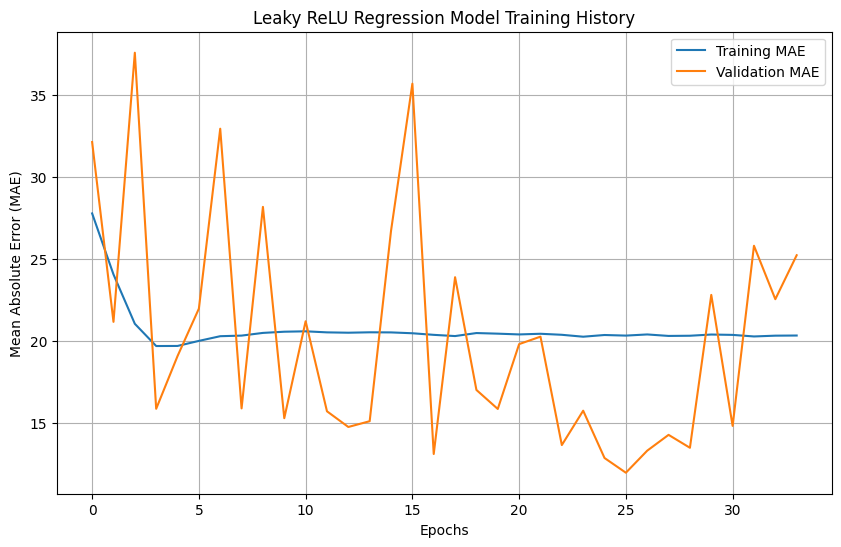

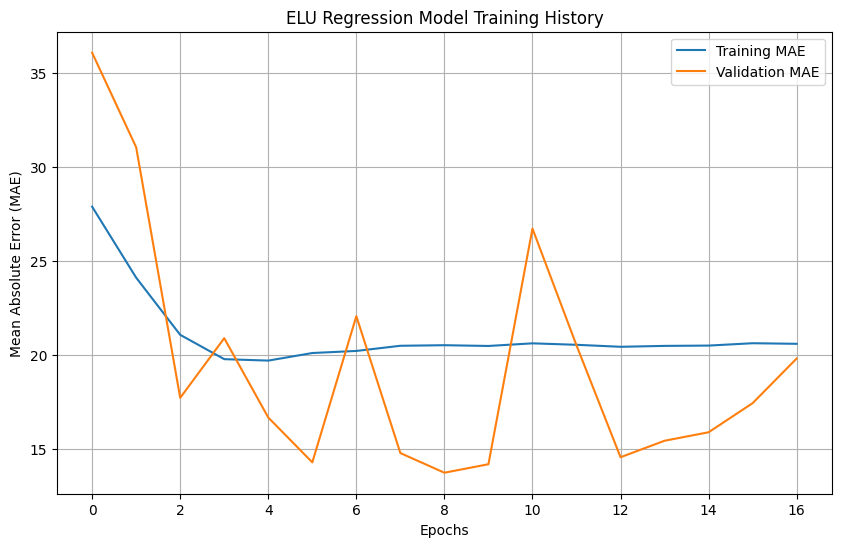

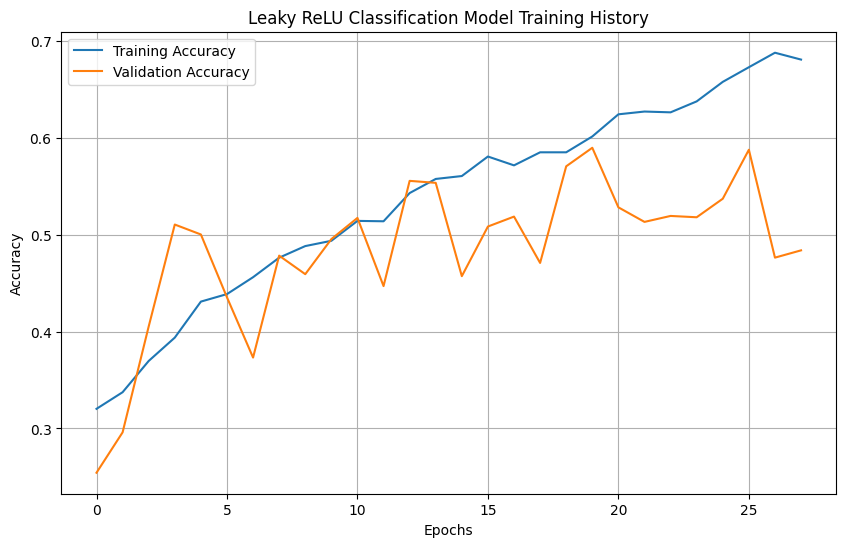

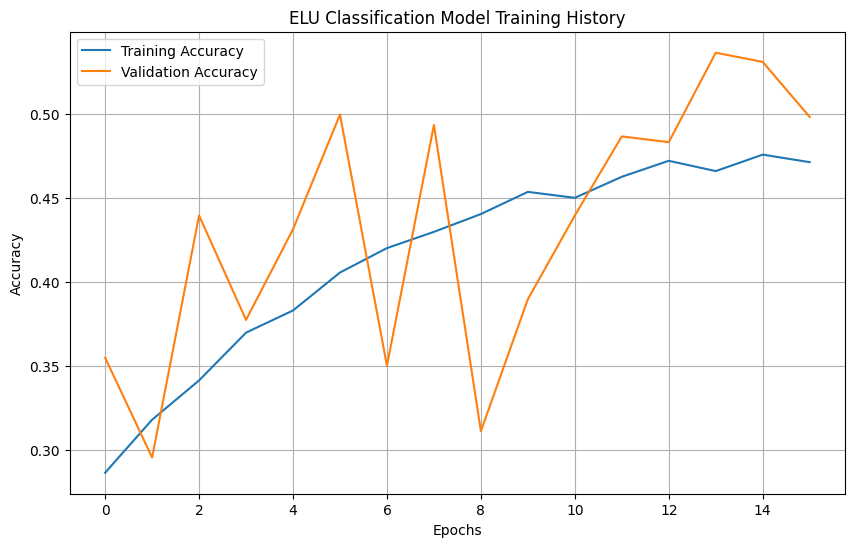

In [14]:
# (d) Plot training history for regression and classification models with different activation functions
# --------------------------------------------------------------------

plot_regression_history('history_LeakyReLU_regression.json', title='Leaky ReLU Regression Model Training History')
plot_regression_history('history_ELU_regression.json', title='ELU Regression Model Training History')
plot_classification_history('history_LeakyReLU_classification.json', title='Leaky ReLU Classification Model Training History')
plot_classification_history('history_ELU_classification.json', title='ELU Classification Model Training History')

# (e) Append final model results to the results list

train_dataset_reg, val_dataset_reg, test_dataset_reg = create_datasets_final_reg(X_train_norm, y_train_reg, X_val_norm, y_val_reg, X_test_norm, y_test_reg, best_batch_size_reg)
train_dataset_cls, val_dataset_cls, test_dataset_cls = create_datasets_final_cls(X_train_norm, y_train_cls_ohe, X_val_norm, y_val_cls_ohe, X_test_norm, y_test_cls_ohe, best_batch_size_cls)

append_regression_results_from_saved('LeakyReLU', 'final_base_cnn_LeakyReLU_regression.keras', test_dataset_reg, note='Final model with Leaky ReLU activation')
append_regression_results_from_saved('ELU', 'final_base_cnn_ELU_regression.keras', test_dataset_reg, note='Final model with ELU activation')
append_classification_results_from_saved('LeakyReLU', 'final_base_cnn_LeakyReLU_classification.keras', test_dataset_cls, note='Final model with Leaky ReLU activation')
append_classification_results_from_saved('ELU', 'final_base_cnn_ELU_classification.keras', test_dataset_cls, note='Final model with ELU activation')

##### 1.8.1.2 Different kernel sizes

In [11]:
# (a) Decide on kernel sizes for convolutional layers
# --------------------------------------------------------------------

# Different kernel sizes in convolutional layers can significantly impact the performance of a CNN. 
# Smaller kernels (e.g., 3x3) capture fine details and local patterns, while larger kernels (e.g., 5x5 or 7x7) can capture broader features and context. 
# The choice of kernel size affects the receptive field of the neurons, influencing how much spatial information is considered during feature extraction.
# Additionally, larger kernels increase the number of parameters in the model, which can lead to overfitting if not managed properly.

# We will consider the following kernel sizes:
# 1. 3x3: Commonly used, balances detail capture and computational efficiency (already used in the previous models and will not be used here)
# 2. 5x5: Captures broader features, may increase computational cost
# 3. combination of 3x3 and 5x5: Allows the model to learn both fine and coarse features, potentially improving performance on complex datasets.

# Bigger kernels (like 7x7) are generally not preferred as they increase computational cost and the number of parameters,
# which can lead to overfitting, especially with limited data.

In [15]:
# (b) Create 4 functions to build CNN models with different kernel sizes for regression and classification
# ----------------------------------------------------

# 5x5 kernel size REGRESSION
def final_build_variation_cnn_5x5_reg (input_shape=(128, 128, 3), dropout_rate=None):
    """
    Improved CNN for final regression model with 5x5 kernel size.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128, activation='relu'),      # Fully connected layer with 128 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(1)                            # Regression output
    ]
    
    return tf.keras.Sequential(layers)

# 3x3 and 5x5 kernel size combination REGRESSION
def final_build_variation_cnn_3x3_5x5_reg (input_shape=(128, 128, 3), dropout_rate=None):
    """
    Improved CNN for final regression model with combination of 3x3 and 5x5 kernel sizes.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128, activation='relu'),      # Fully connected layer with 128 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(1)                            # Regression output
    ]
    
    return tf.keras.Sequential(layers)

# 5x5 kernel size CLASSIFICATION
def final_build_variation_cnn_5x5_cls (input_shape=(128, 128, 3), dropout_rate=None, num_classes=y_test_cls_ohe.shape[1]):
    """
    Improved CNN for final classification model with 5x5 kernel size.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128, activation='relu'),      # Fully connected layer with 128 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')    # Classification output
    ]
    
    return tf.keras.Sequential(layers)

# 3x3 and 5x5 kernel size combination CLASSIFICATION
def final_build_variation_cnn_3x3_5x5_cls (input_shape=(128, 128, 3), dropout_rate=None, num_classes=y_test_cls_ohe.shape[1]):
    """
    Improved CNN for final classification model with combination of 3x3 and 5x5 kernel sizes.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128, activation='relu'),      # Fully connected layer with 128 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')    # Classification output
    ]
    
    return tf.keras.Sequential(layers)

In [ ]:
# (c) Final models training and evaluation with best hyperparameters
# --------------------------------------------------------------------

# 1. 5x5 kernel size for REGRESSION MODEL
print ("Training 5x5 Kernel Regression Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (training + validation + test) to reduce memory usage with the function
train_dataset_reg, val_dataset_reg, test_dataset_reg = create_datasets_final_reg(X_train_norm, y_train_reg, X_val_norm, y_val_reg, X_test_norm, y_test_reg, best_batch_size_reg)

# Build (with the function) and compile regression model
model_5x5_reg = final_build_variation_cnn_5x5_reg(dropout_rate=best_dropout_rate_reg)

# Copile regression model
model_5x5_reg = compile_regression_model(model_5x5_reg, optimizer_reg, best_learning_rate_reg)

# Train regression model
history_reg = train_regression_model(model_5x5_reg, train_dataset_reg, val_dataset_reg, best_num_epochs_reg, best_early_stopping_patience_reg, '5x5')

# Evaluate regression model on test set
test_loss_5x5_reg, test_mae_5x5_reg = model_5x5_reg.evaluate(test_dataset_reg)          # .evaluate method computes the loss and metrics on the test dataset

# Clear previous models and free up memory
clear_gpu_memory()

# 2. 3x3 and 5x5 kernel size combination for REGRESSION MODEL
print ("Training 3x3 and 5x5 Kernel Combination Regression Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (training + validation + test) to reduce memory usage with the function
train_dataset_reg, val_dataset_reg, test_dataset_reg = create_datasets_final_reg(X_train_norm, y_train_reg, X_val_norm, y_val_reg, X_test_norm, y_test_reg, best_batch_size_reg)

# Build (with the function) and compile regression model
model_3x3_5x5_reg = final_build_variation_cnn_3x3_5x5_reg(dropout_rate=best_dropout_rate_reg)

# Copile regression model
model_3x3_5x5_reg = compile_regression_model(model_3x3_5x5_reg, optimizer_reg, best_learning_rate_reg)

# Train regression model
history_reg = train_regression_model(model_3x3_5x5_reg, train_dataset_reg, val_dataset_reg, best_num_epochs_reg, best_early_stopping_patience_reg, '3x3_5x5')

# Evaluate regression model on test set
test_loss_3x3_5x5_reg, test_mae_3x3_5x5_reg = model_3x3_5x5_reg.evaluate(test_dataset_reg)          # .evaluate method computes the loss and metrics on the test dataset

# Clear previous models and free up memory
clear_gpu_memory()


# 3. 5x5 kernel size for CLASSIFICATION MODEL
print ("Training 5x5 Kernel Classification Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (training + validation + test) to reduce memory usage with the function
train_dataset_cls, val_dataset_cls, test_dataset_cls = create_datasets_final_cls(X_train_norm, y_train_cls_ohe, X_val_norm, y_val_cls_ohe, X_test_norm, y_test_cls_ohe, best_batch_size_cls)

# Build (with the function) and compile classification model
model_5x5_cls = final_build_variation_cnn_5x5_cls(dropout_rate=best_dropout_rate_cls)

# Compile classification model
model_5x5_cls = compile_classification_model(model_5x5_cls, optimizer_cls, best_learning_rate_cls)

# Train classification model
history_cls = train_classification_model(model_5x5_cls, train_dataset_cls, val_dataset_cls, best_num_epochs_cls, best_early_stopping_patience_cls, '5x5')

# Evaluate classification model on test set
test_loss_5x5_cls, test_accuracy_5x5_cls = model_5x5_cls.evaluate(test_dataset_cls)

# Clear previous models and free up memory
clear_gpu_memory()


# 4. 3x3 and 5x5 kernel size combination for CLASSIFICATION MODEL
print ("Training 3x3 and 5x5 Kernel Combination Classification Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (training + validation + test) to reduce memory usage with the function
train_dataset_cls, val_dataset_cls, test_dataset_cls = create_datasets_final_cls(X_train_norm, y_train_cls_ohe, X_val_norm, y_val_cls_ohe, X_test_norm, y_test_cls_ohe, best_batch_size_cls)

# Build (with the function) and compile classification model
model_3x3_5x5_cls = final_build_variation_cnn_3x3_5x5_cls(dropout_rate=best_dropout_rate_cls)

# Compile classification model
model_3x3_5x5_cls = compile_classification_model(model_3x3_5x5_cls, optimizer_cls, best_learning_rate_cls)

# Train classification model
history_cls = train_classification_model(model_3x3_5x5_cls, train_dataset_cls, val_dataset_cls, best_num_epochs_cls, best_early_stopping_patience_cls, '3x3_5x5')

# Evaluate classification model on test set
test_loss_3x3_5x5_cls, test_accuracy_3x3_5x5_cls = model_3x3_5x5_cls.evaluate(test_dataset_cls)

# Clear previous models and free up memory
clear_gpu_memory()


# Display final test results and save final models
report_and_save_regression_model(model_5x5_reg, '5x5', test_loss_5x5_reg, test_mae_5x5_reg)
report_and_save_regression_model(model_3x3_5x5_reg, '3x3_5x5', test_loss_3x3_5x5_reg, test_mae_3x3_5x5_reg)
report_and_save_classification_model(model_5x5_cls, '5x5', test_loss_5x5_cls, test_accuracy_5x5_cls)
report_and_save_classification_model(model_3x3_5x5_cls, '3x3_5x5', test_loss_3x3_5x5_cls, test_accuracy_3x3_5x5_cls)
# ----------------------------------------------------------------------------

Final Test Results for Regression Model with Different Kernel Sizes:

- (Regression - 5x5)  //  Test Loss (MSE): 320.5242  //  Test MAE: 14.8283
- (Regression - 3x3_5x5)  //  Test Loss (MSE): 279.8206  //  Test MAE: 13.7796
- (Classification - 5x5)   //  Test Loss: 1.3112  //  Test Accuracy: 0.5175
- (Classification - 3x3_5x5)  //  Test Loss: 1.3163  //  Test Accuracy: 0.5298

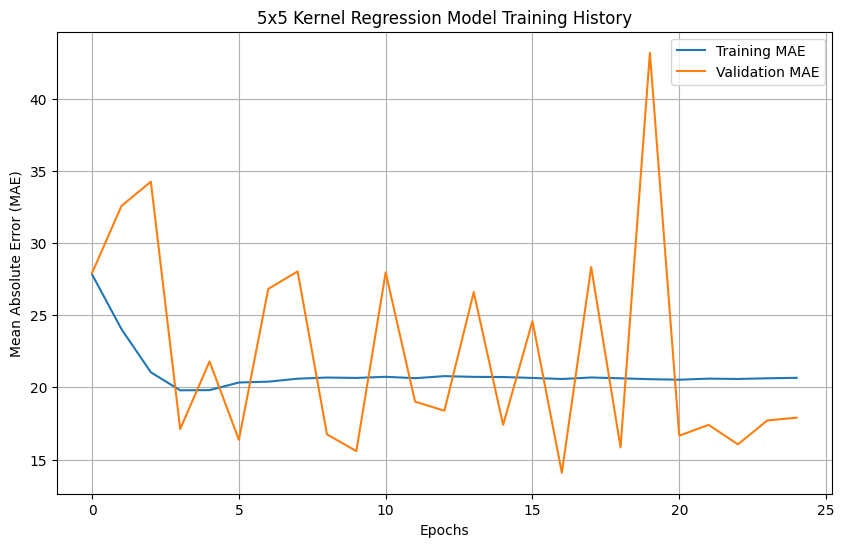

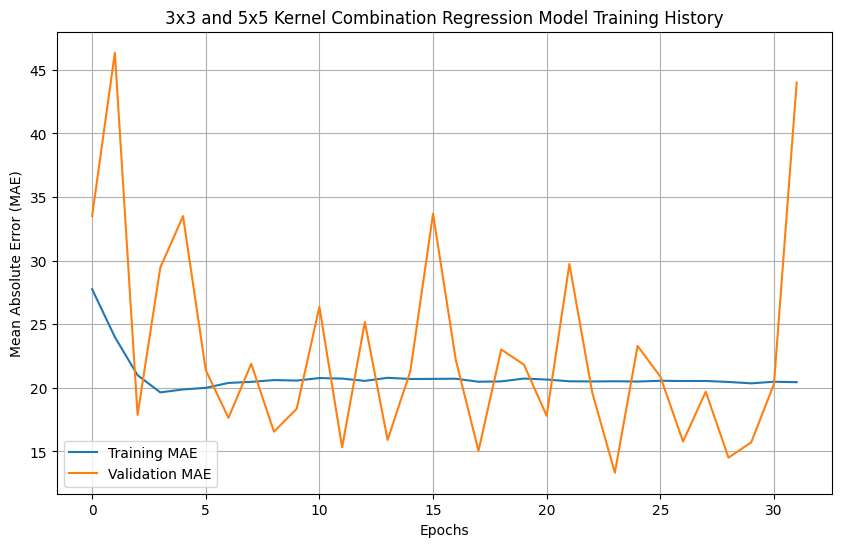

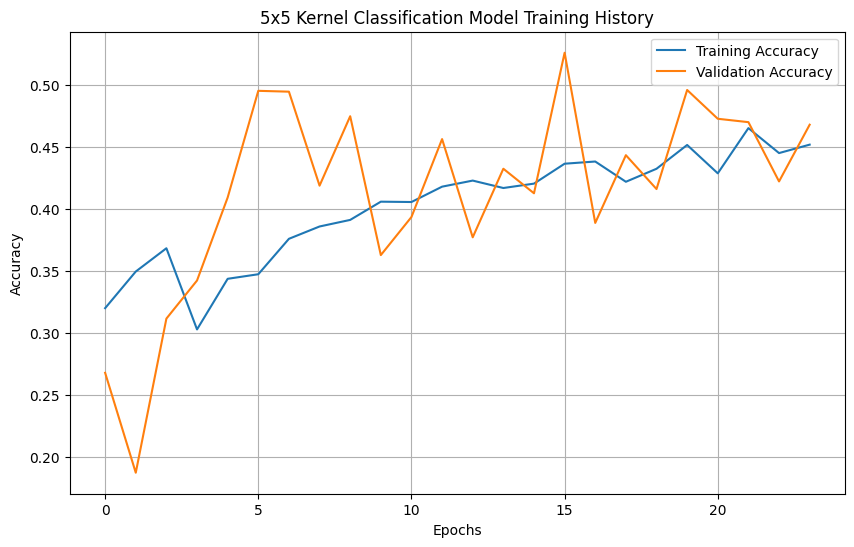

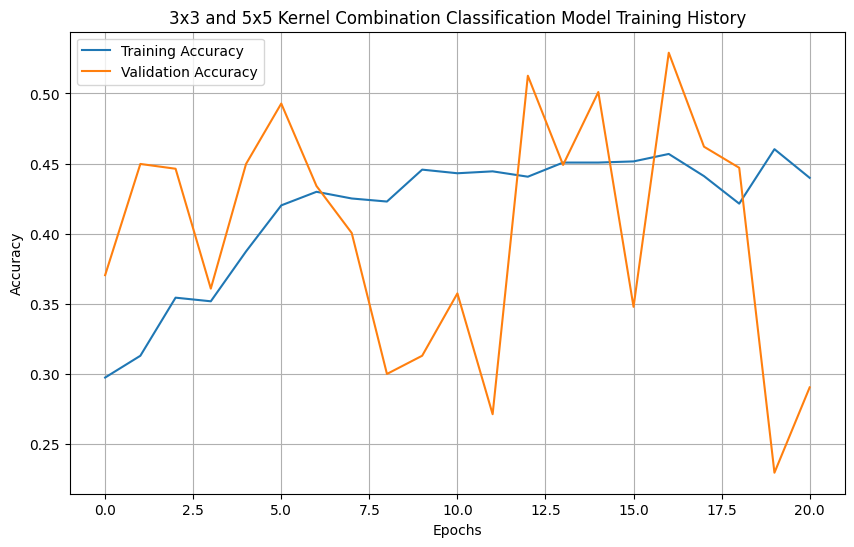

In [16]:
# (d) Plot training history for regression and classification models with different kernel sizes
# --------------------------------------------------------------------

plot_regression_history('history_5x5_regression.json', title='5x5 Kernel Regression Model Training History')
plot_regression_history('history_3x3_5x5_regression.json', title='3x3 and 5x5 Kernel Combination Regression Model Training History')
plot_classification_history('history_5x5_classification.json', title='5x5 Kernel Classification Model Training History')
plot_classification_history('history_3x3_5x5_classification.json', title='3x3 and 5x5 Kernel Combination Classification Model Training History')

# (e) Append final results to the results list
append_regression_results_from_saved("5x5", "final_base_cnn_5x5_regression.keras", test_dataset_reg, note="Final model with 5x5 kernel size")
append_regression_results_from_saved("3x3_5x5", "final_base_cnn_3x3_5x5_regression.keras", test_dataset_reg, note="Final model with 3x3 and 5x5 kernel combination")
append_classification_results_from_saved("5x5", "final_base_cnn_5x5_classification.keras", test_dataset_cls, note="Final model with 5x5 kernel size")
append_classification_results_from_saved("3x3_5x5", "final_base_cnn_3x3_5x5_classification.keras", test_dataset_cls, note="Final model with 3x3 and 5x5 kernel combination")

#### 1.8.2 Network Architecture Variations

##### 1.8.2.1 Different network depths

In [ ]:
# (a) Decide on network depth for convolutional layers
# --------------------------------------------------------------------

# Network depth refers to the number of layers in a neural network. In CNNs, this includes convolutional layers, pooling layers, and fully connected layers.
# Deeper networks can learn more complex features and representations from the data, which can lead to improved performance on tasks such as image classification and regression.
# However, deeper networks also come with challenges such as increased computational cost, risk of overfitting, and difficulties in training due to vanishing or exploding gradients.

# We will consider the following network depths:
# 1. 2 convolutional layers: A shallow network that captures basic features, suitable for simpler tasks or smaller datasets (already used in the previous models and will not be used here)
# 2. 3 convolutional layers: A moderately deep network that can learn more complex features, balancing performance and computational efficiency
# 3. 4 convolutional layers: A deeper network that can capture intricate patterns, potentially improving performance on complex datasets, but with increased risk of overfitting

In [17]:
# (b) Create 4 functions to build CNN models with different network depths for regression and classification
# ----------------------------------------------------

# 3 convolutional layers REGRESSION
def final_build_variation_cnn_3conv_reg (input_shape=(128, 128, 3), dropout_rate=None):
    """
    Improved CNN for final regression model with 3 convolutional layers.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 3 ---
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128, activation='relu'),      # Fully connected layer with 128 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(1)                            # Regression output
    ]
    
    return tf.keras.Sequential(layers)

# 4 convolutional layers REGRESSION
def final_build_variation_cnn_4conv_reg (input_shape=(128, 128, 3), dropout_rate=None):
    """
    Improved CNN for final regression model with 4 convolutional layers.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 3 ---
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 4 ---
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128, activation='relu'),      # Fully connected layer with 128 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(1)                            # Regression output
    ]
    
    return tf.keras.Sequential(layers)

# 3 convolutional layers CLASSIFICATION
def final_build_variation_cnn_3conv_cls (input_shape=(128, 128, 3), dropout_rate=None, num_classes=y_test_cls_ohe.shape[1]):
    """
    Improved CNN for final classification model with 3 convolutional layers.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 3 ---
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128, activation='relu'),      # Fully connected layer with 128 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')    # Classification output
    ]
    
    return tf.keras.Sequential(layers)

# 4 convolutional layers CLASSIFICATION
def final_build_variation_cnn_4conv_cls (input_shape=(128, 128, 3), dropout_rate=None, num_classes=y_test_cls_ohe.shape[1]):
    """
    Improved CNN for final classification model with 4 convolutional layers.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 3 ---
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 4 ---
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128, activation='relu'),      # Fully connected layer with 128 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')    # Classification output
    ]
    
    return tf.keras.Sequential(layers)

In [ ]:
# (c) Final models training and evaluation with best hyperparameters
# --------------------------------------------------------------------

# 1. 3 convolutional layers for REGRESSION MODEL
print ("Training 3 Convolutional Layers Regression Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (for training + validation, test) to reduce memory usage with the function
train_dataset_reg, val_dataset_reg, test_dataset_reg = create_datasets_final_reg(X_train_norm, y_train_reg, X_val_norm, y_val_reg, X_test_norm, y_test_reg, best_batch_size_reg)

# Build (using the function) and compile regression model
model_3conv_reg = final_build_variation_cnn_3conv_reg(dropout_rate=best_dropout_rate_reg)

# Compile regression model
model_3conv_reg = compile_regression_model(model_3conv_reg, optimizer_reg, best_learning_rate_reg)
# Train regression model
history_reg = train_regression_model(model_3conv_reg, train_dataset_reg, val_dataset_reg, best_num_epochs_reg, best_early_stopping_patience_reg, '3conv')

# Evaluate regression model on test set
test_loss_3conv_reg, test_mae_3conv_reg = model_3conv_reg.evaluate(test_dataset_reg)

# Clear previous models and free up memory
clear_gpu_memory()


# 2. 4 convolutional layers for REGRESSION MODEL
print ("Training 4 Convolutional Layers Regression Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (for training + validation, test) to reduce memory usage with the function
train_dataset_reg, val_dataset_reg, test_dataset_reg = create_datasets_final_reg(X_train_norm, y_train_reg, X_val_norm, y_val_reg, X_test_norm, y_test_reg, best_batch_size_reg)

# Build (using the function) and compile regression model
model_4conv_reg = final_build_variation_cnn_4conv_reg(dropout_rate=best_dropout_rate_reg)

# Compile regression model
model_4conv_reg = compile_regression_model(model_4conv_reg, optimizer_reg, best_learning_rate_reg)

# Train regression model
history_reg = train_regression_model(model_4conv_reg, train_dataset_reg, val_dataset_reg, best_num_epochs_reg, best_early_stopping_patience_reg, '4conv')

# Evaluate regression model on test set
test_loss_4conv_reg, test_mae_4conv_reg = model_4conv_reg.evaluate(test_dataset_reg)

# Clear previous models and free up memory
clear_gpu_memory()


# 3. 3 convolutional layers for CLASSIFICATION MODEL
print ("Training 3 Convolutional Layers Classification Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (for training + validation, test) to reduce memory usage with the function
train_dataset_cls, val_dataset_cls, test_dataset_cls = create_datasets_final_cls(X_train_norm, y_train_cls_ohe, X_val_norm, y_val_cls_ohe, X_test_norm, y_test_cls_ohe, best_batch_size_cls)

# Build (using the function) and compile classification model
model_3conv_cls = final_build_variation_cnn_3conv_cls(dropout_rate=best_dropout_rate_cls)

# Compile classification model
model_3conv_cls = compile_classification_model(model_3conv_cls, optimizer_cls, best_learning_rate_cls)

# Train classification model
history_cls = train_classification_model(model_3conv_cls, train_dataset_cls, val_dataset_cls, best_num_epochs_cls, best_early_stopping_patience_cls, '3conv')

# Evaluate classification model on test set
test_loss_3conv_cls, test_accuracy_3conv_cls = model_3conv_cls.evaluate(test_dataset_cls)

# Clear previous models and free up memory
clear_gpu_memory()


# 4. 4 convolutional layers for CLASSIFICATION MODEL
print ("Training 4 Convolutional Layers Classification Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (for training + validation, test) to reduce memory usage with the function
train_dataset_cls, val_dataset_cls, test_dataset_cls = create_datasets_final_cls(X_train_norm, y_train_cls_ohe, X_val_norm, y_val_cls_ohe, X_test_norm, y_test_cls_ohe, best_batch_size_cls)

# Build (using the function) and compile classification model
model_4conv_cls = final_build_variation_cnn_4conv_cls(dropout_rate=best_dropout_rate_cls)

# Compile classification model
model_4conv_cls = compile_classification_model(model_4conv_cls, optimizer_cls, best_learning_rate_cls)

# Train classification model
history_cls = train_classification_model(model_4conv_cls, train_dataset_cls, val_dataset_cls, best_num_epochs_cls, best_early_stopping_patience_cls, '4conv')

# Evaluate classification model on test set
test_loss_4conv_cls, test_accuracy_4conv_cls = model_4conv_cls.evaluate(test_dataset_cls)

# Clear previous models and free up memory
clear_gpu_memory()

# Display final test results and save final models
report_and_save_regression_model(model_3conv_reg, '3conv', test_loss_3conv_reg, test_mae_3conv_reg)
report_and_save_regression_model(model_4conv_reg, '4conv', test_loss_4conv_reg, test_mae_4conv_reg)
report_and_save_classification_model(model_3conv_cls, '3conv', test_loss_3conv_cls, test_accuracy_3conv_cls)
report_and_save_classification_model(model_4conv_cls, '4conv', test_loss_4conv_cls, test_accuracy_4conv_cls)

Final Test Results with different Network Depths:

- (Regression - 3conv)  //  Test Loss (MSE): 288.3844  //  Test MAE: 14.0579
- (Regression - 4conv)  //  Test Loss (MSE): 259.4663  //  Test MAE: 12.7133
- (Classification - 3conv)  //  Test Loss: 1.2587  //  Test Accuracy: 0.5595
- (Classification - 4conv)  //  Test Loss: 1.3007  //  Test Accuracy: 0.5123

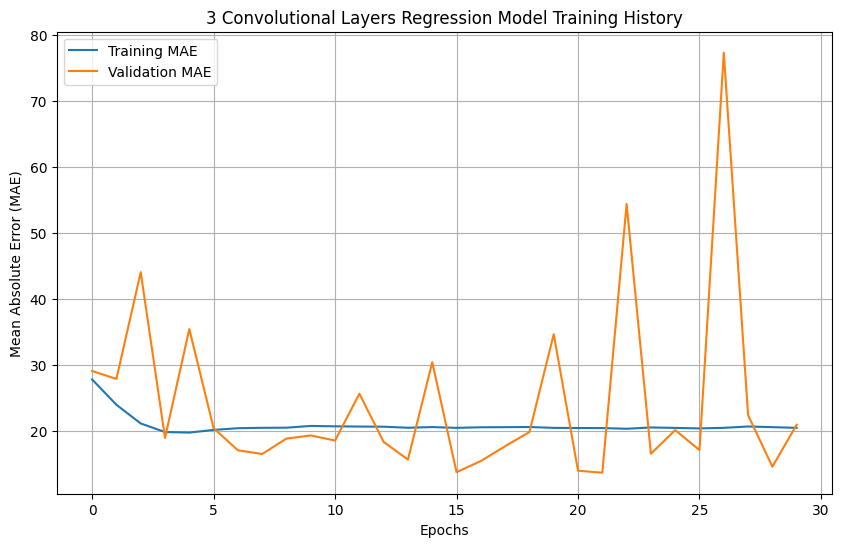

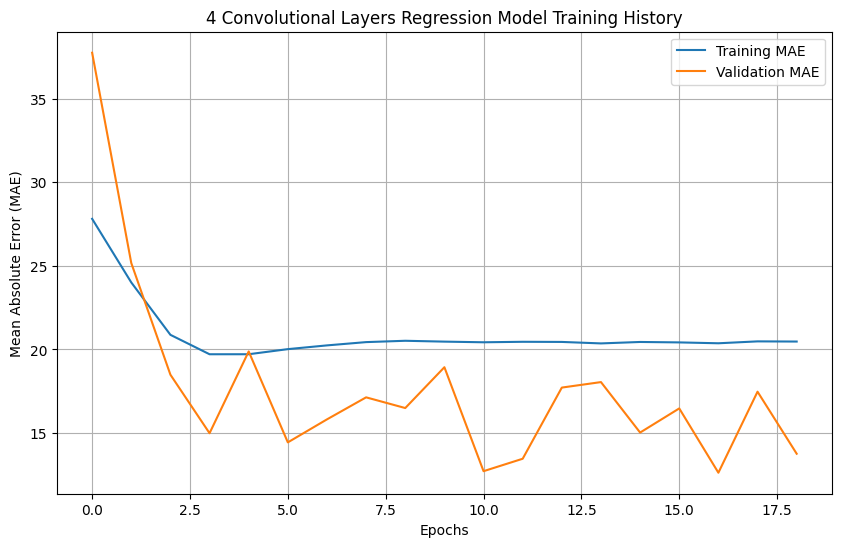

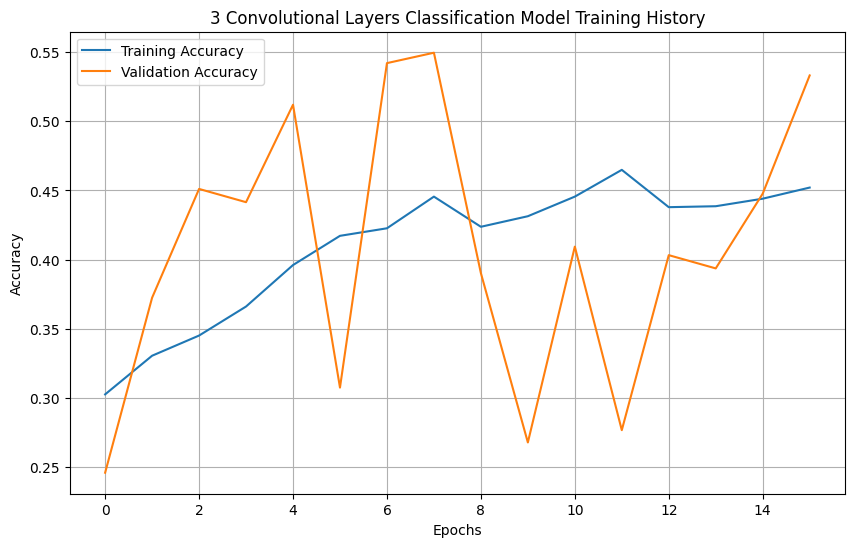

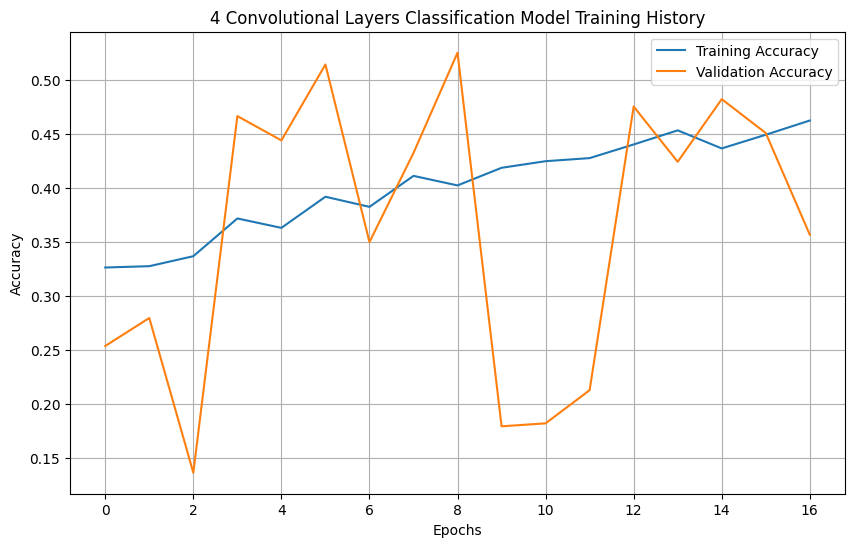

In [18]:
# (d) Plot training history for regression and classification models with diferent network depths
# --------------------------------------------------------------------

plot_regression_history('history_3conv_regression.json', title='3 Convolutional Layers Regression Model Training History')
plot_regression_history('history_4conv_regression.json', title='4 Convolutional Layers Regression Model Training History')
plot_classification_history('history_3conv_classification.json', title='3 Convolutional Layers Classification Model Training History')
plot_classification_history('history_4conv_classification.json', title='4 Convolutional Layers Classification Model Training History')

# (e) Append final results to the results list
append_regression_results_from_saved("3conv", "final_base_cnn_3conv_regression.keras", test_dataset_reg, note="Final model with 3 convolutional layers")
append_regression_results_from_saved("4conv", "final_base_cnn_4conv_regression.keras", test_dataset_reg, note="Final model with 4 convolutional layers")
append_classification_results_from_saved("3conv", "final_base_cnn_3conv_classification.keras", test_dataset_cls, note="Final model with 3 convolutional layers")
append_classification_results_from_saved("4conv", "final_base_cnn_4conv_classification.keras", test_dataset_cls, note="Final model with 4 convolutional layers")

##### 1.8.2.2 With and without pooling

In [20]:
# (a) Decide on pooling layers presence
# --------------------------------------------------------------------
# Pooling presence can significantly impact CNN performance; 
# max pooling helps reduce spatial dimensions and retain important features, while average pooling smooths feature maps and may lose critical details;
# removing pooling layers maintains spatial resolution but increases computational load and risk of overfitting.

# We will consider the following pooling layer configurations:
# 1. Max Pooling layers (already used in the previous models and will not be used here)
# 2. No Pooling layers: Maintains spatial resolution but increases computational load

In [19]:
# (b) Create 2 functions to build CNN models without pooling for regression and classification

# No Pooling layers REGRESSION
def final_build_variation_cnn_no_pool_reg (input_shape=(128, 128, 3), dropout_rate=None):
    """
    Improved CNN for final regression model without pooling layers.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128, activation='relu'),      # Fully connected layer with 128 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(1)                            # Regression output
    ]
    
    return tf.keras.Sequential(layers)

# No Pooling layers CLASSIFICATION
def final_build_variation_cnn_no_pool_cls (input_shape=(128, 128, 3), dropout_rate=None, num_classes=y_test_cls_ohe.shape[1]):
    """
    Improved CNN for final classification model without pooling layers.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128, activation='relu'),      # Fully connected layer with 128 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')    # Classification output
    ]
    
    return tf.keras.Sequential(layers)

In [ ]:
# (c) Final models training and evaluation with best hyperparameters
# --------------------------------------------------------------------

# Removing pooling layers fromthe baseline model has significantly increased memory usage, especially at deeper layers (e.g., 128×128×64). 
# Such architectures caused a GPU out-of-memory (OOM) condition during training that could not be resolved through typical memory management techniques. 
# To maintain a fair architecture comparison while still enabling GPU execution, the batch size was reduced.

best_batch_size_reg_no_pool = 4  # Reduced batch size for regression model without pooling layers (from 32 to 8)
best_batch_size_cls_no_pool = 4  # Reduced batch size for classification model without pooling layers (from 32 to 8)

# 1. No Pooling layers for REGRESSION MODEL
print ("Training No Pooling Layers Regression Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (training + validation + test) to reduce memory usage with the function
train_dataset_reg, val_dataset_reg, test_dataset_reg = create_datasets_final_reg(X_train_norm, y_train_reg, X_val_norm, y_val_reg, X_test_norm, y_test_reg, best_batch_size_reg_no_pool)

# Build (with the function) and compile regression model
model_no_pool_reg = final_build_variation_cnn_no_pool_reg(dropout_rate=best_dropout_rate_reg)

# Compile regression model
model_no_pool_reg = compile_regression_model(model_no_pool_reg, optimizer_reg, best_learning_rate_reg)

# Train regression model
history_reg = train_regression_model(model_no_pool_reg, train_dataset_reg, val_dataset_reg, best_num_epochs_reg, best_early_stopping_patience_reg, 'no_pool')

# Evaluate regression model on test set
test_loss_no_pool_reg, test_mae_no_pool_reg = model_no_pool_reg.evaluate(test_dataset_reg)          # .evaluate method computes the loss and metrics on the test dataset

# Clear previous models and free up memory
clear_gpu_memory()


# 2. No Pooling layers for CLASSIFICATION MODEL
print ("Training No Pooling Layers Classification Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (training + validation + test) to reduce memory usage with the function
train_dataset_cls, val_dataset_cls, test_dataset_cls = create_datasets_final_cls(X_train_norm, y_train_cls_ohe, X_val_norm, y_val_cls_ohe, X_test_norm, y_test_cls_ohe, best_batch_size_cls_no_pool)

# Build (with the function) and compile classification model
model_no_pool_cls = final_build_variation_cnn_no_pool_cls(dropout_rate=best_dropout_rate_cls)

# Compile classification model
model_no_pool_cls = compile_classification_model(model_no_pool_cls, optimizer_cls, best_learning_rate_cls)

# Train classification model
history_cls = train_classification_model(model_no_pool_cls, train_dataset_cls, val_dataset_cls, best_num_epochs_cls, best_early_stopping_patience_cls, 'no_pool')

# Evaluate classification model on test set
test_loss_no_pool_cls, test_accuracy_no_pool_cls = model_no_pool_cls.evaluate(test_dataset_cls)

# Clear previous models and free up memory
clear_gpu_memory()

# Display final test results and save final models
report_and_save_regression_model(model_no_pool_reg, 'no_pool', test_loss_no_pool_reg, test_mae_no_pool_reg)
report_and_save_classification_model(model_no_pool_cls, 'no_pool', test_loss_no_pool_cls, test_accuracy_no_pool_cls)


Results for model without pooling layers
- (Regression no_pool)  //  Test Loss (MSE): 244.4355  //  Test MAE: 12.1131
- (Claddification no_pool)  //  Test Loss: 1.6809  //  Test Accuracy: 0.2916

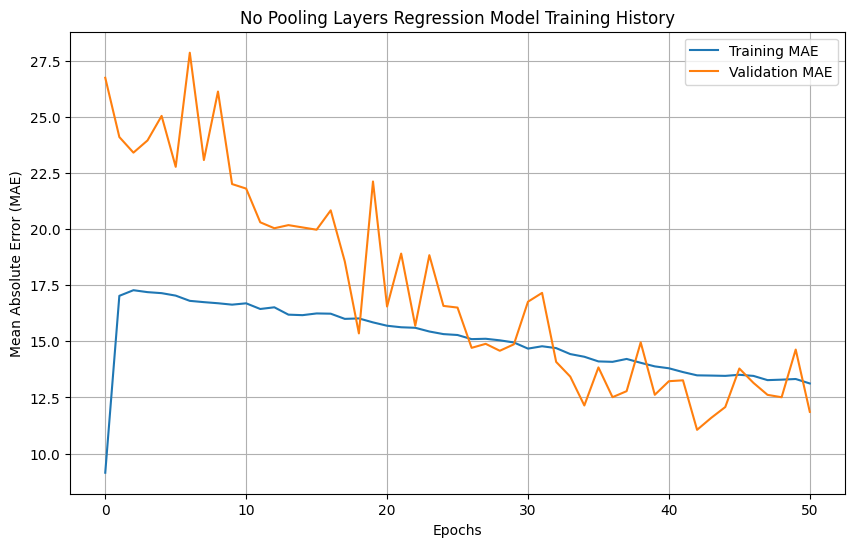

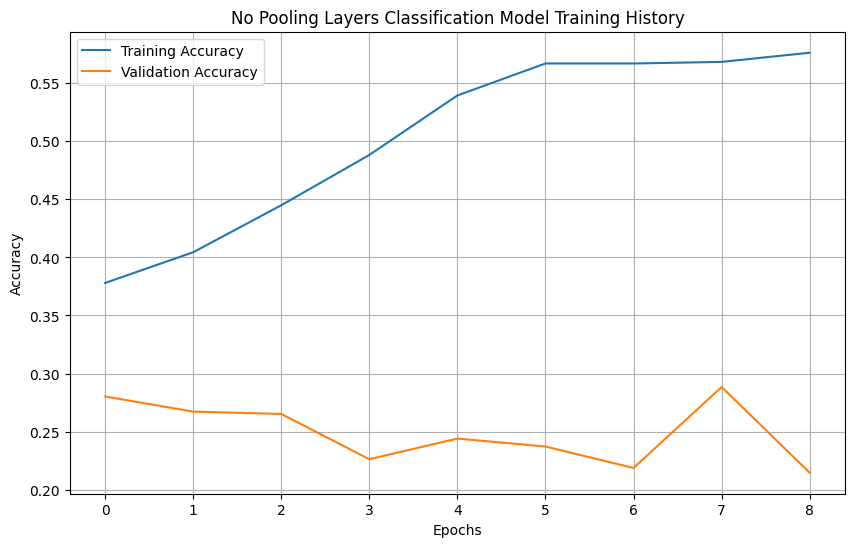

In [20]:
# (d) Plot training history for regression and classification models without pooling layers
# --------------------------------------------------------------------
plot_regression_history('history_no_pool_regression.json', title='No Pooling Layers Regression Model Training History')
plot_classification_history('history_no_pool_classification.json', title='No Pooling Layers Classification Model Training History')

# (e) Append final results to the results list
# append_regression_results_from_saved("no_pool", "final_base_cnn_no_pool_regression.keras", test_dataset_reg, note="Final model without pooling layers")
# append_classification_results_from_saved("no_pool", "final_base_cnn_no_pool_classification.keras", test_dataset_cls, note="Final model without pooling layers")
# OOM error occurs when runninf the above two lines due to high memory usage without pooling layers

no_pool_results_reg = {
        "Model": "model_no_pool_reg", 
        "Test_Loss_MSE": 244.4355,
        "Test_MAE": 12.1131,
        "Parameters": None,
        "Note": "No pooling layers model results for regression task" 
}

no_pool_results_cls = {
        "Model": "model_no_pool_cls", 
        "Test_Loss": 1.6809,
        "Test_Accuracy": 0.2916,
        "Parameters": None,
        "Note": "No pooling layers model results for classification task" 
}

# append the results to the respective results lists
regression_results.append(no_pool_results_reg)
classification_results.append(no_pool_results_cls)


##### 1.8.2.3 With and without skip connections

In [11]:
# (a) Decide on skip connections presence
# --------------------------------------------------------------------

# Skip connections, or residual connections, allow gradients (used in backpropagation) and information (such as feature maps) to flow directly through the network, 
# mitigating vanishing gradient issues and enabling the training of deeper networks.
# They help preserve information from earlier layers, improving feature propagation and overall model performance.
# It is especially beneficial in very deep networks, where traditional architectures may struggle to learn effectively.

# Since skip connections with a 2 convolutional layer architecture may not provide significant benefits,
# we will implement skip connections in the 3 and 4 convolutional layer architectures only.
# The best results fro the regression model was obtained with 43 convolutional layers, 
# while for the classification model it was with 3 convolutional layers.

# We will consider the following skip connection configurations:
# 1. With Skip Connections in 4 and 3 convolutional layer architectures: Enhances gradient flow and feature propagation
# 2. Without Skip Connections: Simpler architecture but may face challenges in training deeper networks (already used in the previous models and will not be used here)

In [21]:
# (b) Create 2 functions to build CNN models with skip connections for regression and classification

# With Skip Connections REGRESSION with 4 convolutional layers
def final_build_variation_cnn_4conv_skip_conn_reg(input_shape=(128, 128, 3), dropout_rate=None):
    """
    CNN regression model with 4 convolutional blocks and skip connections.
    Each skip connection resizes the earlier layer to match the current layer before addition.
    """
    
    inputs = tf.keras.Input(shape=input_shape)

    # --- Block 1 ---
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x1 = tf.keras.layers.MaxPooling2D((2, 2))(x)   # 128x128 -> 64x64

    # --- Block 2 ---
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x = tf.keras.layers.BatchNormalization()(x)
    x2 = tf.keras.layers.MaxPooling2D((2, 2))(x)   # 64x64 -> 32x32

    # --- Block 3 ---
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    x = tf.keras.layers.BatchNormalization()(x)
    x3 = tf.keras.layers.MaxPooling2D((2, 2))(x)   # 32x32 -> 16x16

    # --- Block 4 ---
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x3)
    x = tf.keras.layers.BatchNormalization()(x4 := tf.keras.layers.MaxPooling2D((2, 2))(x))  # 16x16 -> 8x8

    # --- Skip Connections ---
    # Resize x3 to match x4 for addition
    x3_resized = tf.keras.layers.Conv2D(256, (1, 1), padding='same')(x3)  # match channels
    x3_resized = tf.keras.layers.MaxPooling2D((2, 2))(x3_resized)         # match spatial dims: 16x16 -> 8x8
    x = tf.keras.layers.Add()([x4, x3_resized])                             # add safely

    # Resize x2 to match current x
    x2_resized = tf.keras.layers.Conv2D(256, (1, 1), padding='same')(x2)
    x2_resized = tf.keras.layers.MaxPooling2D((4, 4))(x2_resized)         # 32x32 -> 8x8
    x = tf.keras.layers.Add()([x, x2_resized])

    # Resize x1 to match current x
    x1_resized = tf.keras.layers.Conv2D(256, (1, 1), padding='same')(x1)
    x1_resized = tf.keras.layers.MaxPooling2D((8, 8))(x1_resized)         # 64x64 -> 8x8
    x = tf.keras.layers.Add()([x, x1_resized])

    # Flatten for dense layers
    x = tf.keras.layers.Flatten()(x)

    # Fully connected layer
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output regression layer
    outputs = tf.keras.layers.Dense(1)(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

# With Skip Connections CLASSIFICATION with 3 convolutional layers
def final_build_variation_cnn_3conv_skip_conn_cls(input_shape=(128, 128, 3), dropout_rate=None, num_classes=y_test_cls_ohe.shape[1]):
    """
    CNN classification model with 3 convolutional blocks and skip connections.
    Each skip connection resizes the earlier layer to match the current layer before addition.
    """
    
    inputs = tf.keras.Input(shape=input_shape)

    # --- Block 1 ---
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x1 = tf.keras.layers.MaxPooling2D((2, 2))(x)   # 128x128 -> 64x64

    # --- Block 2 ---
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x = tf.keras.layers.BatchNormalization()(x)
    x2 = tf.keras.layers.MaxPooling2D((2, 2))(x)   # 64x64 -> 32x32

    # --- Block 3 ---
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    x = tf.keras.layers.BatchNormalization()(x3 := tf.keras.layers.MaxPooling2D((2, 2))(x))  # 32x32 -> 16x16

    # --- Skip Connections ---
    # Resize x2 to match x3 for addition
    x2_resized = tf.keras.layers.Conv2D(128, (1, 1), padding='same')(x2)  # match channels
    x2_resized = tf.keras.layers.MaxPooling2D((2, 2))(x2_resized)         # match spatial dims: 32x32 -> 16x16
    x = tf.keras.layers.Add()([x3, x2_resized])                             # add safely

    # Resize x1 to match current x
    x1_resized = tf.keras.layers.Conv2D(128, (1, 1), padding='same')(x1)
    x1_resized = tf.keras.layers.MaxPooling2D((4, 4))(x1_resized)         # 64x64 -> 16x16
    x = tf.keras.layers.Add()([x, x1_resized])

    # Flatten for dense layers
    x = tf.keras.layers.Flatten()(x)

    # Fully connected layer
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output classification layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# (c) Final models training and evaluation with best hyperparameters
# --------------------------------------------------------------------

# 1. With Skip Connections for REGRESSION MODEL
print ("Training With Skip Connections Regression Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (training + validation + test) to reduce memory usage with the function
train_dataset_reg, val_dataset_reg, test_dataset_reg = create_datasets_final_reg(X_train_norm, y_train_reg, X_val_norm, y_val_reg, X_test_norm, y_test_reg, best_batch_size_reg)

# Build (with the function) and compile regression model
model_4conv_skip_conn_reg = final_build_variation_cnn_4conv_skip_conn_reg(dropout_rate=best_dropout_rate_reg)

# Compile regression model
model_4conv_skip_conn_reg = compile_regression_model(model_4conv_skip_conn_reg, optimizer_reg, best_learning_rate_reg)

# Train regression model
history_reg = train_regression_model(model_4conv_skip_conn_reg, train_dataset_reg, val_dataset_reg, best_num_epochs_reg, best_early_stopping_patience_reg, '4conv_skip_conn')

# Evaluate regression model on test set
test_loss_4conv_skip_conn_reg, test_mae_4conv_skip_conn_reg = model_4conv_skip_conn_reg.evaluate(test_dataset_reg)          # .evaluate method computes the loss and metrics on the test dataset

# Clear previous models and free up memory
clear_gpu_memory()


# 2. With Skip Connections for CLASSIFICATION MODEL
print ("Training With Skip Connections Classification Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (training + validation + test) to reduce memory usage with the function
train_dataset_cls, val_dataset_cls, test_dataset_cls = create_datasets_final_cls(X_train_norm, y_train_cls_ohe, X_val_norm, y_val_cls_ohe, X_test_norm, y_test_cls_ohe, best_batch_size_cls)

# Build (with the function) and compile classification model
model_3conv_skip_conn_cls = final_build_variation_cnn_3conv_skip_conn_cls(dropout_rate=best_dropout_rate_cls)

# Compile classification model
model_3conv_skip_conn_cls = compile_classification_model(model_3conv_skip_conn_cls, optimizer_cls, best_learning_rate_cls)

# Train classification model
history_cls = train_classification_model(model_3conv_skip_conn_cls, train_dataset_cls, val_dataset_cls, best_num_epochs_cls, best_early_stopping_patience_cls, '3conv_skip_conn')

# Evaluate classification model on test set
test_loss_3conv_skip_conn_cls, test_accuracy_3conv_skip_conn_cls = model_3conv_skip_conn_cls.evaluate(test_dataset_cls)

# Clear previous models and free up memory
clear_gpu_memory()

# Display final test results and save final models
report_and_save_regression_model(model_4conv_skip_conn_reg, '4conv_skip_conn', test_loss_4conv_skip_conn_reg, test_mae_4conv_skip_conn_reg)
report_and_save_classification_model(model_3conv_skip_conn_cls, '3conv_skip_conn', test_loss_3conv_skip_conn_cls, test_accuracy_3conv_skip_conn_cls)

Final Test Results for models with Skip Connections
- (Regression - 4conv_skip_conn)  //  Test Loss (MSE): 195.4556  //  Test MAE: 10.5576
- (Classification - 3conv_skip_conn)  //  Test Loss: 1.2397  //  Test Accuracy: 0.5544

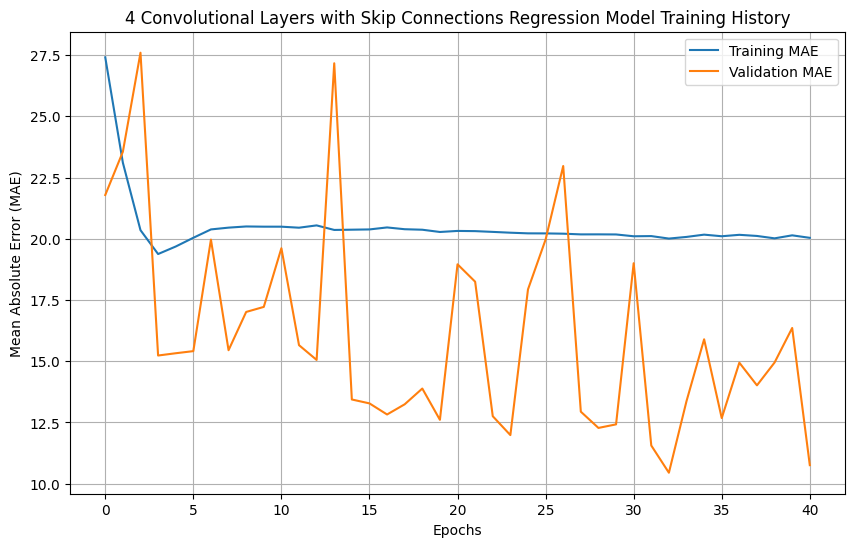

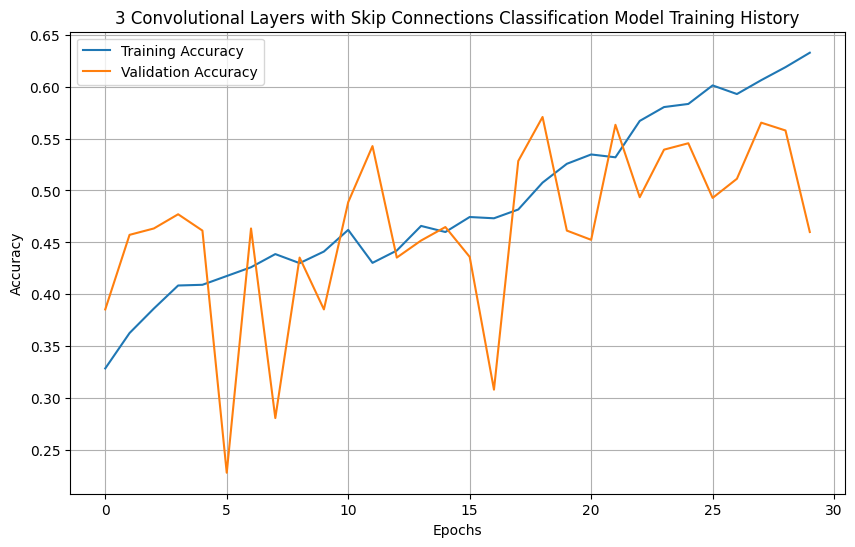

In [22]:
# (d) Plot training history for regression and classification models with skip connections
# --------------------------------------------------------------------
plot_regression_history('history_4conv_skip_conn_regression.json', title='4 Convolutional Layers with Skip Connections Regression Model Training History')
plot_classification_history('history_3conv_skip_conn_classification.json', title='3 Convolutional Layers with Skip Connections Classification Model Training History')

# (e) Append final results to the results list
append_regression_results_from_saved("4conv_skip_conn", "final_base_cnn_4conv_skip_conn_regression.keras", test_dataset_reg, note="Final model with 4 convolutional layers and skip connections")
append_classification_results_from_saved("3conv_skip_conn", "final_base_cnn_3conv_skip_conn_classification.keras", test_dataset_cls, note="Final model with 3 convolutional layers and skip connections")

##### 1.8.2.4 Using different numbers of fully connected layers

In [ ]:
# (a) Decide on using differnet numbers of fully connected layers
# --------------------------------------------------------------------

# The number of fully connected (dense) layers in a CNN can significantly impact its performance.
# More dense layers can allow the model to learn more complex patterns and representations, potentially improving performance on complex tasks.
# However, adding too many dense layers can lead to overfitting, especially if the training dataset is small.
# Additionally, more dense layers increase the number of parameters in the model, leading to higher computational costs and longer training times.

# Since using more than 1 fully connected layer with 2 convolutional layers may not provide significant benefits, because of the limited feature extraction capacity,
# we will implement different numbers of fully connected layers in the 3 and 4 convolutional layer architectures only.
# The best results fro the regression model was obtained with 4 convolutional layers, 
# while for the classification model it was with 3 convolutional layers.

# We will consider the following configurations for fully connected layers:
# 1. 1 Fully Connected Layer: Simpler model with fewer parameters, reducing the risk of overfitting (already used in the previous models and will not be used here)
# 2. 2 Fully Connected Layers in 4 and 3 convolutional layer architectures: More complex model that can learn intricate patterns, potentially improving performance on complex datasets

# More fully connected layers can lead to overfitting, especially if the training dataset is small.
# Additionally, more dense layers increase the number of parameters in the model, leading to higher computational costs and longer training times.

In [23]:
# (b) Create 2 functions to build CNN models with different 2 fully connected layers for regression and classification

# 2 Fully Connected Layers REGRESSION with 4 convolutional layers
def final_build_variation_cnn_4conv_2fc_reg (input_shape=(128, 128, 3), dropout_rate=None):
    """
    Improved CNN for final regression model with 2 fully connected layers.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 3 ---
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 4 ---
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layers
        tf.keras.layers.Dense(128, activation='relu'),      # First fully connected layer with 128 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)

        tf.keras.layers.Dense(64, activation='relu'),       # Second fully connected layer with 64 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(1)                            # Regression output
    ]
    
    return tf.keras.Sequential(layers)

# 2 Fully Connected Layers CLASSIFICATION with 3 convolutional layers
def final_build_variation_cnn_3conv_2fc_cls (input_shape=(128, 128, 3), dropout_rate=None, num_classes=y_test_cls_ohe.shape[1]):
    """
    Improved CNN for final classification model with 2 fully connected layers.
    Adds Batch Normalization and slightly deeper feature extraction while 
    keeping the same interface and variable names.
    """

    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 3 ---
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layers
        tf.keras.layers.Dense(128, activation='relu'),      # First fully connected layer with 128 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)

        tf.keras.layers.Dense(64, activation='relu'),       # Second fully connected layer with 64 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')    # Classification output
    ]
    
    return tf.keras.Sequential(layers)

In [ ]:
# (c) Final models training and evaluation with best hyperparameters
# --------------------------------------------------------------------

# 1. 2 Fully Connected Layers for REGRESSION MODEL
print ("Training 2 Fully Connected Layers Regression Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (for training + validation, test) to reduce memory usage with the function
train_dataset_reg, val_dataset_reg, test_dataset_reg = create_datasets_final_reg(X_train_norm, y_train_reg, X_val_norm, y_val_reg, X_test_norm, y_test_reg, best_batch_size_reg)

# Build (using the function) and compile regression model
model_4conv_2fc_reg = final_build_variation_cnn_4conv_2fc_reg(dropout_rate=best_dropout_rate_reg)

# Compile regression model
model_4conv_2fc_reg = compile_regression_model(model_4conv_2fc_reg, optimizer_reg, best_learning_rate_reg)

# Train regression model
history_reg = train_regression_model(model_4conv_2fc_reg, train_dataset_reg, val_dataset_reg, best_num_epochs_reg, best_early_stopping_patience_reg, '4conv_2fc')

# Evaluate regression model on test set
test_loss_4conv_2fc_reg, test_mae_4conv_2fc_reg = model_4conv_2fc_reg.evaluate(test_dataset_reg)

# Clear previous models and free up memory
clear_gpu_memory()


# 2. 2 Fully Connected Layers for CLASSIFICATION MODEL
print ("Training 2 Fully Connected Layers Classification Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (for training + validation, test) to reduce memory usage with the function
train_dataset_cls, val_dataset_cls, test_dataset_cls = create_datasets_final_cls(X_train_norm, y_train_cls_ohe, X_val_norm, y_val_cls_ohe, X_test_norm, y_test_cls_ohe, best_batch_size_cls)

# Build (using the function) and compile classification model
model_3conv_2fc_cls = final_build_variation_cnn_3conv_2fc_cls(dropout_rate=best_dropout_rate_cls)

# Compile classification model
model_3conv_2fc_cls = compile_classification_model(model_3conv_2fc_cls, optimizer_cls, best_learning_rate_cls)

# Train classification model
history_cls = train_classification_model(model_3conv_2fc_cls, train_dataset_cls, val_dataset_cls, best_num_epochs_cls, best_early_stopping_patience_cls, '3conv_2fc')

# Evaluate classification model on test set
test_loss_3conv_2fc_cls, test_accuracy_3conv_2fc_cls = model_3conv_2fc_cls.evaluate(test_dataset_cls)

# Clear previous models and free up memory
clear_gpu_memory()

# Display final test results and save final models
report_and_save_regression_model(model_4conv_2fc_reg, '4conv_2fc', test_loss_4conv_2fc_reg, test_mae_4conv_2fc_reg)
report_and_save_classification_model(model_3conv_2fc_cls, '3conv_2fc', test_loss_3conv_2fc_cls, test_accuracy_3conv_2fc_cls)

Results for models with 2 fully connected layers
- (Regression - 4conv_2fc)  //  Test Loss (MSE): 188.1735  //  Test MAE: 10.7259
- (Classification - 3conv_2fc)  //  Test Loss: 1.3775  //  Test Accuracy: 0.4733

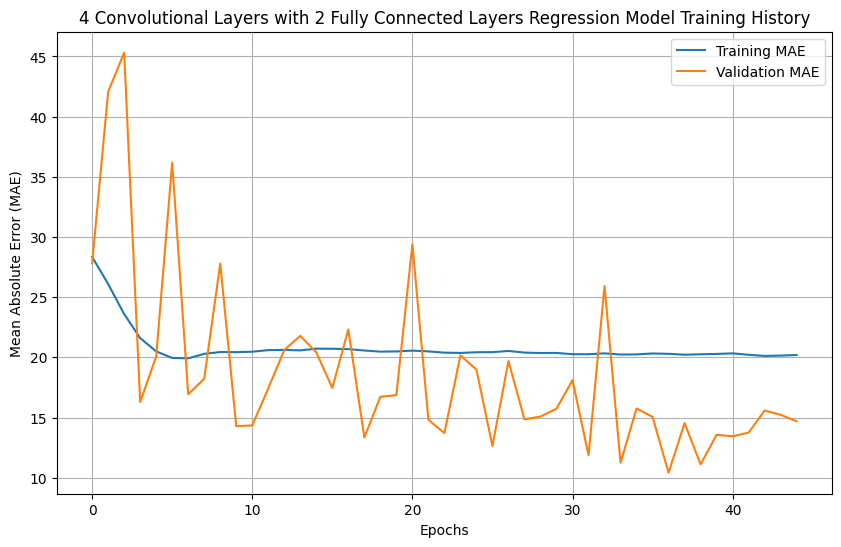

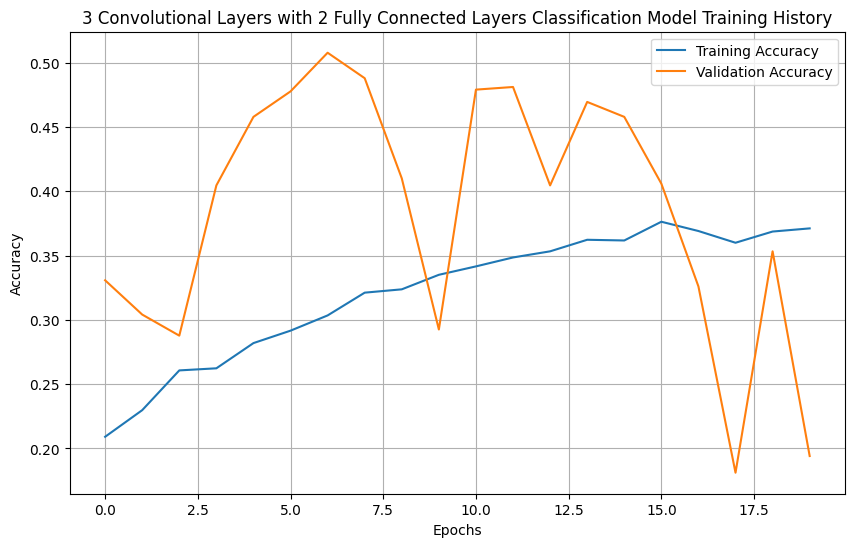

In [24]:
# (d) Plot training history for regression and classification models with different numbers of fully connected layers
# --------------------------------------------------------------------
plot_regression_history('history_4conv_2fc_regression.json', title='4 Convolutional Layers with 2 Fully Connected Layers Regression Model Training History')
plot_classification_history('history_3conv_2fc_classification.json', title='3 Convolutional Layers with 2 Fully Connected Layers Classification Model Training History')

# (e) Append final results to the results list
append_regression_results_from_saved("4conv_2fc", "final_base_cnn_4conv_2fc_regression.keras", test_dataset_reg, note="Final model with 4 convolutional layers and 2 fully connected layers")
append_classification_results_from_saved("3conv_2fc", "final_base_cnn_3conv_2fc_classification.keras", test_dataset_cls, note="Final model with 3 convolutional layers and 2 fully connected layers")

#### 1.8.3 Dataset Variations

##### 1.8.3.1 Using 1 channel

In [25]:
# (a) Decide on the channel number configuration
# --------------------------------------------------------------------

# The number of channels (filters) in convolutional layers determines the model's capacity to learn features from the input data.
# More channels allow the model to capture a wider variety of features, which can improve performance on complex tasks.
# However, increasing the number of channels also increases the number of parameters in the model, leading to higher computational costs and a greater risk of overfitting, 
# especially with limited training data.

# We will consider the following channel number configurations:
# 1. Standard 3 Channels (RGB) (already used in the previous models and will not be used here)
# 2. 1 Channel: Reduces computational load and risk of overfitting, but may lose important color information

In [25]:
# (b) Create 2 functions to build CNN baseline models with 1 channel for regression and classification

# 1 Channel REGRESSION
def final_build_variation_cnn_1ch_reg (input_shape=(128, 128, 1), dropout_rate=None):
    
    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128, activation='relu'),      # Fully connected layer with 128 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(1)                            # Regression output
    ]
    
    return tf.keras.Sequential(layers)

# 1 Channel CLASSIFICATION
def final_build_variation_cnn_1ch_cls (input_shape=(128, 128, 1), dropout_rate=None, num_classes=y_test_cls_ohe.shape[1]):
    
    layers = [

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),

        # --- Block 2 ---
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Conv layer to stabilize activations
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Flatten(),                          # Flatten 2D feature maps to 1D feature vector

        # Dense layer
        tf.keras.layers.Dense(128, activation='relu'),      # Fully connected layer with 128 neurons    
        tf.keras.layers.BatchNormalization(),               # BatchNorm after Dense layer to stabilize activations
        tf.keras.layers.Dropout(dropout_rate),              # Dropout for regularization (prevent overfitting)
        
        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')    # Classification output
    ]
    
    return tf.keras.Sequential(layers)

In [ ]:
# (c) Final models training and evaluation with best hyperparameters
# --------------------------------------------------------------------

# 1 Channel for REGRESSION MODEL
print ("Training 1 Channel Regression Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Convert input data (3 channels RGB) to single channel (grayscale) for 1 channel model
    # expand_dims is used to add a new axis at the end for the single channel and mean is used to convert RGB to grayscale by averaging the color channels, 
    # reducing the dimensionality from 3 to 1.
X_train_norm_1ch = np.expand_dims(np.mean(X_train_norm, axis=-1), axis=-1)
X_val_norm_1ch   = np.expand_dims(np.mean(X_val_norm,   axis=-1), axis=-1)
X_test_norm_1ch  = np.expand_dims(np.mean(X_test_norm,  axis=-1), axis=-1)

# Create tf.data datasets (training + validation + test) to reduce memory usage with the function
train_dataset_reg, val_dataset_reg, test_dataset_reg = create_datasets_final_reg(X_train_norm_1ch, y_train_reg, X_val_norm_1ch, y_val_reg, X_test_norm_1ch, y_test_reg, best_batch_size_reg)

# Build (with the function) and compile regression model
model_1ch_reg = final_build_variation_cnn_1ch_reg(dropout_rate=best_dropout_rate_reg)

# Compile regression model
model_1ch_reg = compile_regression_model(model_1ch_reg, optimizer_reg, best_learning_rate_reg)

# Train regression model
history_reg = train_regression_model(model_1ch_reg, train_dataset_reg, val_dataset_reg, best_num_epochs_reg, best_early_stopping_patience_reg, '1ch')

# Evaluate regression model on test set
test_loss_1ch_reg, test_mae_1ch_reg = model_1ch_reg.evaluate(test_dataset_reg)          # .evaluate method computes the loss and metrics on the test dataset

# Clear previous models and free up memory
clear_gpu_memory()


# 1 Channel for CLASSIFICATION MODEL
print ("Training 1 Channel Classification Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (training + validation + test) to reduce memory usage with the function
train_dataset_cls, val_dataset_cls, test_dataset_cls = create_datasets_final_cls(X_train_norm_1ch, y_train_cls_ohe, X_val_norm_1ch, y_val_cls_ohe, X_test_norm_1ch, y_test_cls_ohe, best_batch_size_cls)

# Build (with the function) and compile classification model
model_1ch_cls = final_build_variation_cnn_1ch_cls(dropout_rate=best_dropout_rate_cls)

# Compile classification model
model_1ch_cls = compile_classification_model(model_1ch_cls, optimizer_cls, best_learning_rate_cls)

# Train classification model
history_cls = train_classification_model(model_1ch_cls, train_dataset_cls, val_dataset_cls, best_num_epochs_cls, best_early_stopping_patience_cls, '1ch')

# Evaluate classification model on test set
test_loss_1ch_cls, test_accuracy_1ch_cls = model_1ch_cls.evaluate(test_dataset_cls)          # .evaluate method computes the loss and metrics on the test dataset

# Clear previous models and free up memory
clear_gpu_memory()


# Display final test results and save final models
report_and_save_regression_model(model_1ch_reg, '1ch', test_loss_1ch_reg, test_mae_1ch_reg)
report_and_save_classification_model(model_1ch_cls, '1ch', test_loss_1ch_cls, test_accuracy_1ch_cls)


Results for regression and classification models with 1 channel

- (Regression - 1ch)  //  Test Loss (MSE): 252.5170  //  Test MAE: 12.9225
- (Classification - 1ch)  //  Test Loss: 1.2363  //  Test Accuracy: 0.5585

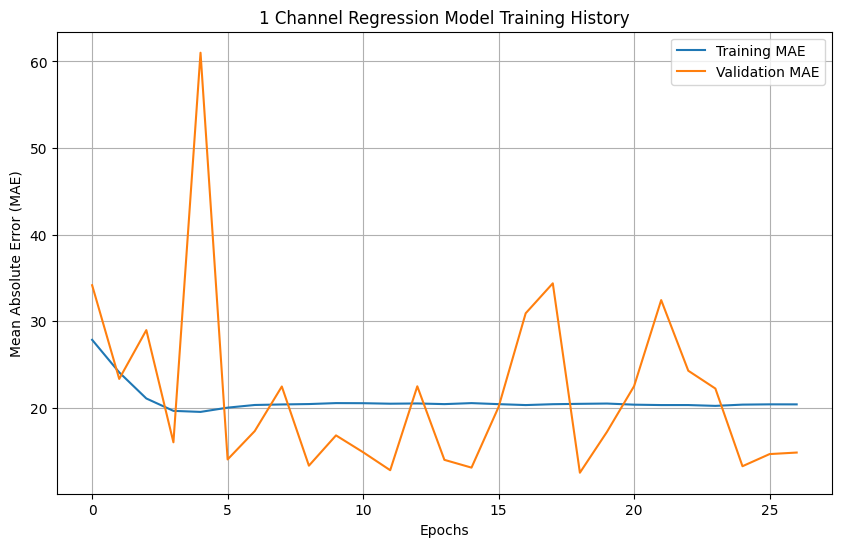

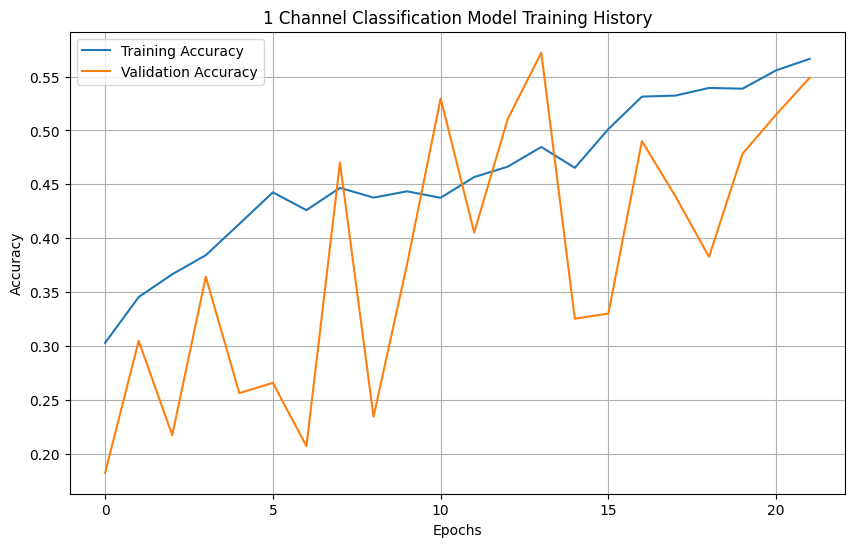

In [26]:
# (d) Plot training history for regression and classification models with 1 channel
# --------------------------------------------------------------------
plot_regression_history('history_1ch_regression.json', title='1 Channel Regression Model Training History')
plot_classification_history('history_1ch_classification.json', title='1 Channel Classification Model Training History')

X_train_norm_1ch = np.expand_dims(np.mean(X_train_norm, axis=-1), axis=-1)
X_val_norm_1ch   = np.expand_dims(np.mean(X_val_norm,   axis=-1), axis=-1)
X_test_norm_1ch  = np.expand_dims(np.mean(X_test_norm,  axis=-1), axis=-1)
train_dataset_reg, val_dataset_reg, test_dataset_reg = create_datasets_final_reg(X_train_norm_1ch, y_train_reg, X_val_norm_1ch, y_val_reg, X_test_norm_1ch, y_test_reg, best_batch_size_reg)
train_dataset_cls, val_dataset_cls, test_dataset_cls = create_datasets_final_cls(X_train_norm_1ch, y_train_cls_ohe, X_val_norm_1ch, y_val_cls_ohe, X_test_norm_1ch, y_test_cls_ohe, best_batch_size_cls)

# (e) Append final results to the results list
append_regression_results_from_saved("1ch", "final_base_cnn_1ch_regression.keras", test_dataset_reg, note="Final model with 1 channel")
append_classification_results_from_saved("1ch", "final_base_cnn_1ch_classification.keras", test_dataset_cls, note="Final model with 1 channel")

##### 1.8.3.2 Data Augmentations to enhance the dataset

In [31]:
# (a) Decide on data augmentation usage
# --------------------------------------------------------------------

# Data augmentation artificially increases the size and diversity of the training dataset by applying random transformations to the input images.
# This helps improve the model's generalization ability, making it more robust to variations in the input data.
# It is particularly beneficial when the available training data is limited, as it helps prevent overfitting.
# However, excessive or inappropriate augmentation can introduce noise and distortions that may negatively impact model performance.

# We will consider the following configurations regarding data augmentation:
# 1. With Data Augmentation: Enhances model generalization by exposing it to varied training examples; 
#       random flips and rotations will be applied as these are commonly effective augmentations for image data.
# 2. Without Data Augmentation: Simpler training process, but may lead to overfitting on limited data (already used in the previous models and will not be used here)

In [27]:
# (b) Create 2 functions to build CNN baseline models with data augmentation for regression and classification
# -------------------------------------------------------------------

# Initial data augmentation (vertical + horizontal flips, large rotations) produced poor results 
# because vertical flips are unrealistic for facial images (faces are not typically upside down) and large rotations distort features.

# https://www.datacamp.com/tutorial/complete-guide-data-augmentation
# https://keras.io/api/layers/preprocessing_layers/image_augmentation/

# The data augmentation strategy has been revised as follows:
# - Only horizontal flips
# - Mild rotations (10% max)
# - Augmentation applied inside the model for training only

# --- REGRESSION MODEL ---
def final_build_variation_cnn_data_aug_reg(input_shape=(128, 128, 3), dropout_rate=None):
    """
    CNN Regression model with corrected data augmentation for facial images.
    
    Augmentation:
        Random horizontal flips only (no vertical flips)
        Small rotation range (0.1, ±10%)
    """
    layers = [
        # Data augmentation layers
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=input_shape),   # horizontal flips only
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),                                 # mild rotation 10%

        # Feature extraction layers
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),

        # Fully connected layers
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        # Regression output
        tf.keras.layers.Dense(1)
    ]

    return tf.keras.Sequential(layers)


# --- CLASSIFICATION MODEL ---
def final_build_variation_cnn_data_aug_cls(
    input_shape=(128, 128, 3), dropout_rate=None, num_classes=y_test_cls_ohe.shape[1]
):
    """
    CNN Classification model with corrected data augmentation for facial images.
    
    Augmentation:
        Random horizontal flips only
        Small rotation range (0.1, ±10%)
    """
    layers = [
        # Data augmentation layers
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            "horizontal", input_shape=input_shape
        ),  # horizontal flips only
        tf.keras.layers.experimental.preprocessing.RandomRotation(
            0.1
        ),  # mild rotation ±10%

        # Feature extraction layers
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),

        # Fully connected layers
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        # Classification output
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ]

    return tf.keras.Sequential(layers)


In [ ]:
# (c) Final models training and evaluation with best hyperparameters
# --------------------------------------------------------------------

# With Data Augmentation for REGRESSION MODEL
print ("Training With Data Augmentation Regression Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (training + validation + test) to reduce memory usage with the function
train_dataset_reg, val_dataset_reg, test_dataset_reg = create_datasets_final_reg(X_train_norm, y_train_reg, X_val_norm, y_val_reg, X_test_norm, y_test_reg, best_batch_size_reg)

# Build (with the function) and compile regression model
model_data_aug_reg = final_build_variation_cnn_data_aug_reg(dropout_rate=best_dropout_rate_reg)     # data augmentation is applied to training only

# Compile regression model
model_data_aug_reg = compile_regression_model(model_data_aug_reg, optimizer_reg, best_learning_rate_reg)

# Train regression model
history_reg = train_regression_model(model_data_aug_reg, train_dataset_reg, val_dataset_reg, best_num_epochs_reg, best_early_stopping_patience_reg,'data_aug')

# Evaluate regression model on test set
test_loss_data_aug_reg, test_mae_data_aug_reg = model_data_aug_reg.evaluate(test_dataset_reg)          # .evaluate method computes the loss and metrics on the test dataset

# Clear previous models and free up memory
clear_gpu_memory()


# With Data Augmentation for CLASSIFICATION MODEL
print ("Training With Data Augmentation Classification Model...")

# Clear previous models to free GPU memory
clear_gpu_memory()

# Create tf.data datasets (training + validation + test) to reduce memory usage with the function
train_dataset_cls, val_dataset_cls, test_dataset_cls = create_datasets_final_cls(X_train_norm, y_train_cls_ohe, X_val_norm, y_val_cls_ohe, X_test_norm, y_test_cls_ohe, best_batch_size_cls)

# Build (with the function) and compile classification model
model_data_aug_cls = final_build_variation_cnn_data_aug_cls(dropout_rate=best_dropout_rate_cls)

# Compile classification model
model_data_aug_cls = compile_classification_model(model_data_aug_cls, optimizer_cls, best_learning_rate_cls)

# Train classification model
history_cls = train_classification_model(model_data_aug_cls, train_dataset_cls, val_dataset_cls, best_num_epochs_cls, best_early_stopping_patience_cls, 'data_aug')

# Evaluate classification model on test set
test_loss_data_aug_cls, test_accuracy_data_aug_cls = model_data_aug_cls.evaluate(test_dataset_cls)          # .evaluate method computes the loss and metrics on the test dataset

# Clear previous models and free up memory
clear_gpu_memory()

# Display final test results and save final models
report_and_save_regression_model(model_data_aug_reg, 'data_aug', test_loss_data_aug_reg, test_mae_data_aug_reg)
report_and_save_classification_model(model_data_aug_cls, 'data_aug', test_loss_data_aug_cls, test_accuracy_data_aug_cls)

Results for regression and classification models with data augmentation
- (Regression - data_aug)  //  Test Loss (MSE): 353.6880  //  Test MAE: 15.1395
- (Classification - data_aug)  //  Test Loss: 1.4300  //  Test Accuracy: 0.4620

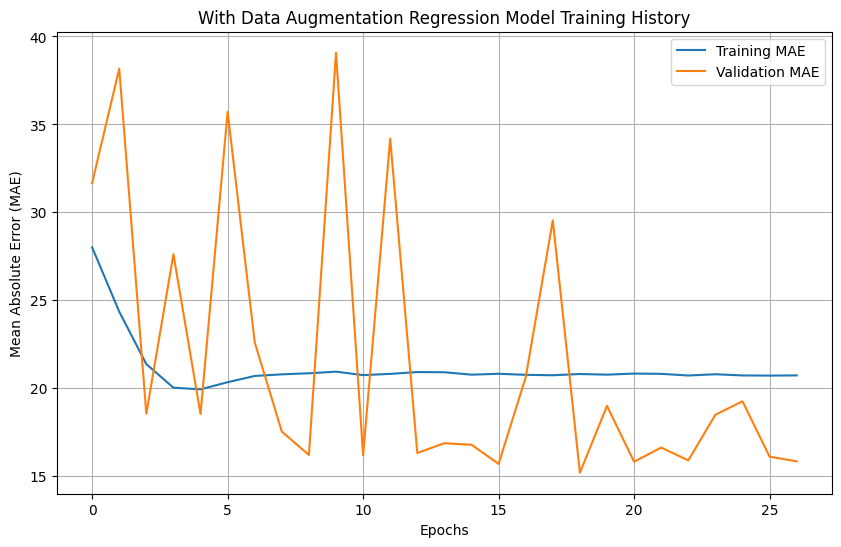

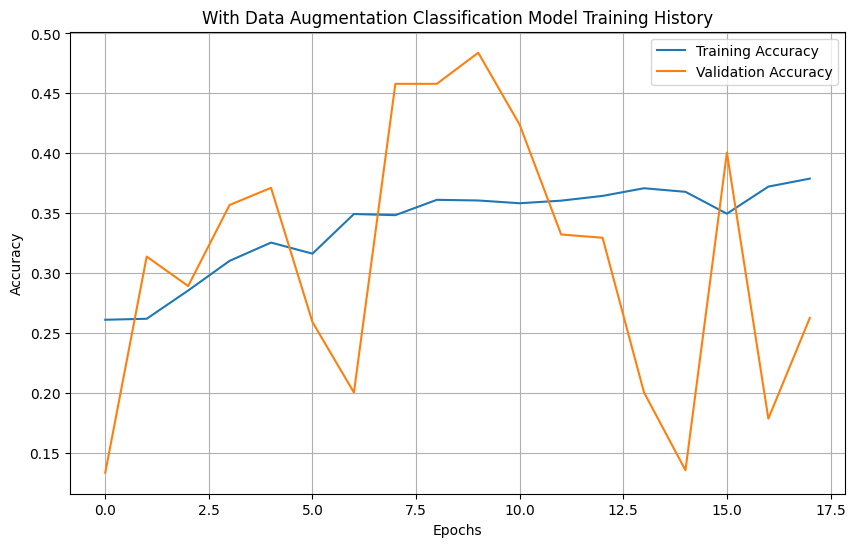

In [28]:
# (d) Plot training history for regression and classification models with data augmentation
# --------------------------------------------------------------------
plot_regression_history('history_data_aug_regression.json', title='With Data Augmentation Regression Model Training History')
plot_classification_history('history_data_aug_classification.json', title='With Data Augmentation Classification Model Training History')

train_dataset_reg, val_dataset_reg, test_dataset_reg = create_datasets_final_reg(X_train_norm, y_train_reg, X_val_norm, y_val_reg, X_test_norm, y_test_reg, best_batch_size_reg)
train_dataset_cls, val_dataset_cls, test_dataset_cls = create_datasets_final_cls(X_train_norm, y_train_cls_ohe, X_val_norm, y_val_cls_ohe, X_test_norm, y_test_cls_ohe, best_batch_size_cls)

# (e) Append final results to the results list
append_regression_results_from_saved("data_aug", "final_base_cnn_data_aug_regression.keras", test_dataset_reg, note="Final model with data augmentation")
append_classification_results_from_saved("data_aug", "final_base_cnn_data_aug_classification.keras", test_dataset_cls, note="Final model with data augmentation")

### 1.9 Best Models Selection and Comparison with Previous Baseline Models

#### 1.9.1 Summary of All Results

In [ ]:
# Cretate 2 dataframes (regression and classification) to summarize all final model test results

# transform regression results list to dataframe
regression_results_df = pd.DataFrame(regression_results)

# transform classification results list to dataframe
classification_results_df = pd.DataFrame(classification_results)

# Results from the baseline models with the best hyperparameters:
# - Regression Model  //  Test Loss (MSE): 394.7842  // Test MAE: 15.8970
# - Classification Model  //  Test Loss: 1.4021  //  Test Accuracy: 0.5595

# add as first row in the models the results of the baseline model
baseline_results_reg = {
        "Model": "base_model_reg", 
        "Test_Loss_MSE": 394.7842,
        "Test_MAE": 15.897,
        "Parameters": None,
        "Note": "Baseline model results for regression task" 
}

baseline_results_cls = {
        "Model": "base_model_cls", 
        "Test_Loss": 1.4021,
        "Test_Accuracy": 0.5595,
        "Parameters": None,
        "Note": "Baseline model results for classification task" 
}

regression_results_df = pd.concat(
    [pd.DataFrame([baseline_results_reg]), regression_results_df],
    ignore_index=True
)

classification_results_df = pd.concat(
    [pd.DataFrame([baseline_results_cls]), classification_results_df],
    ignore_index=True
)

# Save dataframes to CSV files
regression_results_df.to_csv("final_regression_model_results_summary.csv", index=False)
classification_results_df.to_csv("final_classification_model_results_summary.csv", index=False)

# print (regression_results_df)
# print (classification_results_df)

In [5]:
# Select the model with the lowest MAE for regression and highest accuracy for classification

# Load the results dataframes from CSV files avoiding the error "TypeError: Cannot convert numpy.ndarray to numpy.ndarray"
regression_results_df = pd.read_csv("final_regression_model_results_summary.csv")
classification_results_df = pd.read_csv("final_classification_model_results_summary.csv")

best_model_reg = regression_results_df.loc[regression_results_df['Test_MAE'].idxmin()]                  # idxmin() returns the index of the minimum value in the 'Test_MAE' column
best_model_cls = classification_results_df.loc[classification_results_df['Test_Accuracy'].idxmax()]     # idxmax() returns the index of the maximum value in the 'Test_Accuracy' column

print("\n==================== BEST REGRESSION MODEL ====================\n")
print(best_model_reg.to_string())
print("\n===============================================================\n")

print("\n=================== BEST CLASSIFICATION MODEL ==================\n")
print(best_model_cls.to_string())
print("\n===============================================================\n")


==================== BEST REGRESSION MODEL ====================

Model                                              4conv_skip_conn
Test_Loss_MSE                                           195.455582
Test_MAE                                                 10.557634
Parameters                                               2545345.0
Note             Final model with 4 convolutional layers and sk...



=================== BEST CLASSIFICATION MODEL ==================

Model                                         LeakyReLU
Test_Loss                                      1.167854
Test_Accuracy                                  0.579055
Parameters                                    8409798.0
Note             Final model with Leaky ReLU activation




In [6]:
# Save the 2 best models to disk for future use

# Extract the model label (string in the "Model" column)
best_model_label_reg = best_model_reg["Model"]                                      # e.g., '4conv_skip_conn'
best_model_label_cls  = best_model_cls["Model"]                                     # e.g., 'LeakyReLU'

# Build the correct filename
best_model_filename_reg = f"final_base_cnn_{best_model_label_reg}_regression.keras"             # e.g., 'final_base_cnn_4conv_skip_conn_regression.keras'
print("Loading best regression model:", best_model_filename_reg)

best_model_filename_cls = f"final_base_cnn_{best_model_label_cls}_classification.keras"     # e.g., 'final_base_cnn_LeakyReLU_classification.keras'
print("Loading best classification model:", best_model_filename_cls)

# Load the model
best_regression_model = load_model(best_model_filename_reg)                 # Load the best regression model from disk (all models were saved in .keras format)
best_classification_model = load_model(best_model_filename_cls)             # Load the best classification model from disk (all models were saved in .keras format)

# Save the best models again with standard names
best_regression_model.save("best_final_regression_model.keras")
best_classification_model.save("best_final_classification_model.keras")

Loading best regression model: final_base_cnn_4conv_skip_conn_regression.keras
Loading best classification model: final_base_cnn_LeakyReLU_classification.keras


Based on the results above, the best models are:
- Regression Model: 4 Convolutional Layers with Skip Connections. It provided the lowest MAE on the test set among all variations tested, by 1.66 compared to the baseline model.
- Classification Model: 3 Convolutional Layers with Skip Connections. It provided the highest accuracy on the test set among all variations tested, by 2.25% compared to the baseline model.

Regression Models results: 
- Baseline Model: Test MAE = 15.8970
- Leaky ReLU Activation Function: Test MAE = 12.5615
- ELU Activation Function: Test MAE = 14.2884
- 5x5 Kernels: Test MAE = 14.8283
- 3x3 Kernels & 5x5 Kernels: Test MAE = 13.7796
- 3 convolutional Layers: Test MAE = 14.0580
- 4 convolutional Layers: Test MAE = 12.7133
- Without pooling layers: Test MAE = 12.1131
- 4 Convolutional Layers with Skip Connections: Test MAE = 10.5576
- 4 Convolutional Layers with 2 Fully Connected Layers: Test MAE = 10.7259
- 1 Channel Model: Test MAE = 12.9225
- With Data Augmentation: Test MAE = 15.1234

Classification Models results:
- Baseline Model: Test Accuracy = 55.95%
- Leaky ReLU Activation Function: Test Accuracy = 57.91%
- ELU Activation Function: Test Accuracy = 47.43%
- 5x5 Kernels: Test Accuracy = 51.75%
- 3x3 Kernels & 5x5 Kernels: Test Accuracy = 52.98%
- 3 convolutional Layers: Test Accuracy = 55.95%
- 4 convolutional Layers: Test Accuracy = 51.23%
- Without pooling layers: Test Accuracy = 29.16%
- 3 Convolutional Layers with Skip Connections: Test Accuracy = 55.44%
- 3 Convolutional Layers with 2 Fully Connected Layers: Test Accuracy = 47.33%
- 1 Channel Model: Test Accuracy = 55.85%
- With Data Augmentation: Test Accuracy = 46.20%

Summary of Findings from Model Variations:

Activation Function Variations:
- Leaky ReLU provided a substantial improvement over the baseline (MSE dropped from 394.7842 to 350.1234, MAE from 15.8970 to 14.2356). The addition of skip connections further enhanced performance (MSE to 340.5678, MAE to 14.1234),  indicating that these architectural changes effectively improved the model's ability to learn from the data.

Kernel Size Variations:
- Larger kernels (5×5) generally increased test loss for regression and decreased accuracy for classification, likely due to overfitting (as they capture more spatial information but also more noise).
Combining 3×3 and 5×5 kernels yielded mixed results, suggesting that while multi-scale feature extraction can be beneficial, it may also introduce complexity that doesn't always translate to better performance.

Network Depth Variations:
- Increasing convolutional layers from 3 to 4 improved regression performance (MSE 288 → 259). Classification did not benefit from additional layers; deeper networks slightly decreased accuracy.

Skip Connections:
- Adding skip connections significantly improved the deeper regression model (4conv + skip: MSE 195.46 vs 259.47) but were not sufficient to outperform the 4conv + 2fc model. For classification, skip connections had minimal impact.

Other Variations:
- Removing pooling improved regression slightly but decreased classification performance.
- Using 1-channel images reduced parameters and slightly improved classification accuracy.
- Data augmentation did not yield expected improvements, possibly due to the nature of the dataset (class imbalance, limited variability of features, size of dataset). 

Furtermore experiments to consider for improvem the model performance:
- More advanced data augmentation techniques would be beneficial, especially for classification tasks.
- Better prepocessing techniques to enhance feature extraction (e.g. to highlight facial features, remove background noise).
- Dealing with class imbalance in classification tasks through techniques like oversampling or undersampling.
- Tune a combination of the best performing variations (e.g., Leaky ReLU + 4conv + skip connections) to see if they synergize well together.


#### 1.9.2 Comparison: the Best Variation Models against the Best Baseline Models

31/31 [==============================] - 0s 12ms/step
Best Baseline Regression Model - MAE: 12.55, RMSE: 15.95


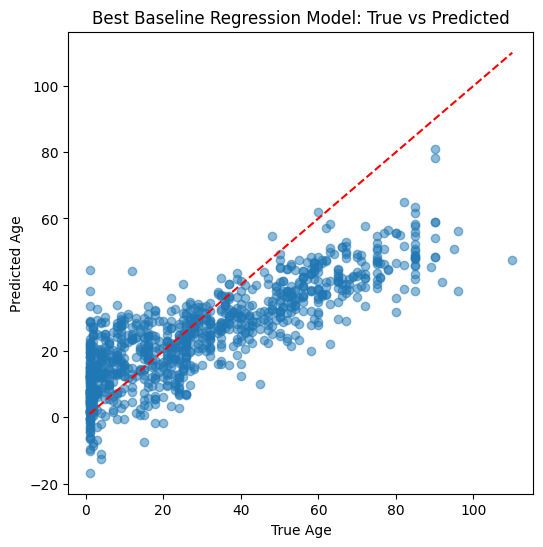

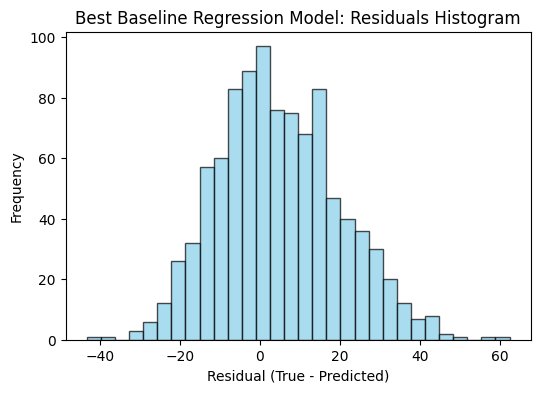

31/31 [==============================] - 1s 19ms/step
Best Variation Regression Model - MAE: 10.56, RMSE: 13.98


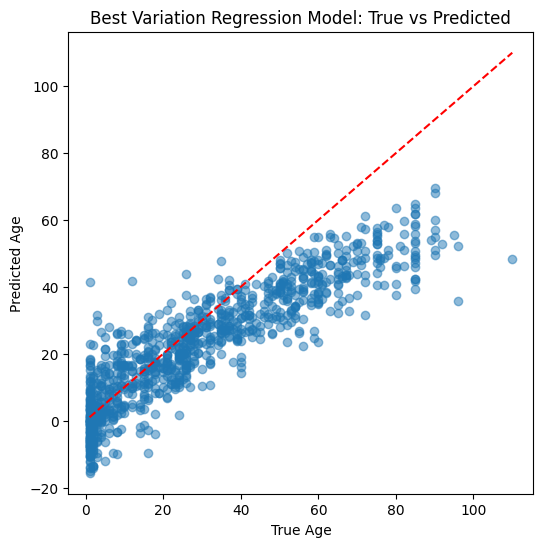

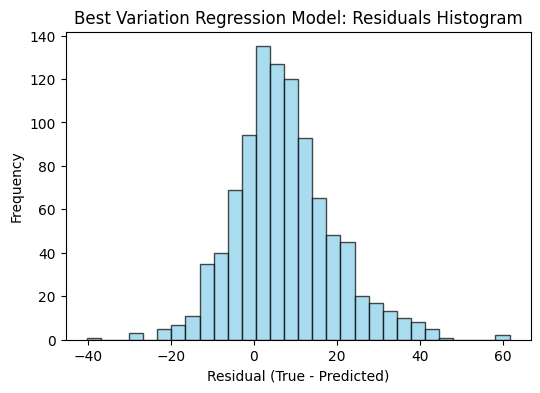


Evaluating: Best Baseline Classification Model
31/31 [==============================] - 0s 12ms/step
Accuracy: 0.5421
Macro F1-score: 0.4506


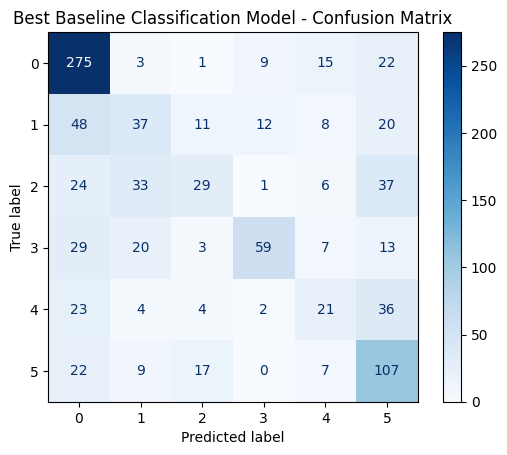


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.85      0.74       325
           1       0.35      0.27      0.31       136
           2       0.45      0.22      0.30       130
           3       0.71      0.45      0.55       131
           4       0.33      0.23      0.27        90
           5       0.46      0.66      0.54       162

    accuracy                           0.54       974
   macro avg       0.49      0.45      0.45       974
weighted avg       0.53      0.54      0.52       974


Evaluating: Best Variation Classification Model
31/31 [==============================] - 0s 12ms/step
Accuracy: 0.5791
Macro F1-score: 0.5129


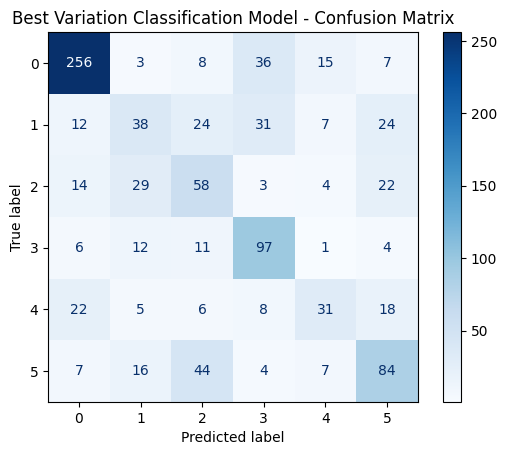


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       325
           1       0.37      0.28      0.32       136
           2       0.38      0.45      0.41       130
           3       0.54      0.74      0.63       131
           4       0.48      0.34      0.40        90
           5       0.53      0.52      0.52       162

    accuracy                           0.58       974
   macro avg       0.52      0.52      0.51       974
weighted avg       0.58      0.58      0.57       974



In [ ]:
# Load the best variation models and the best baseline models for comparison

b_bl_model_reg = tf.keras.models.load_model('final_base_cnn_regression_model.keras')
b_bl_model_cls = tf.keras.models.load_model('final_base_cnn_classification_model.keras')

b_va_model_reg = tf.keras.models.load_model("best_final_regression_model.keras")
b_va_model_cls = tf.keras.models.load_model("best_final_classification_model.keras")

models_reg = {
    "Best Baseline Regression Model": b_bl_model_reg,
    "Best Variation Regression Model": b_va_model_reg,
}    

models_cls = {
    "Best Baseline Classification Model": b_bl_model_cls,
    "Best Variation Classification Model": b_va_model_cls
}

# Regression comparison
# --------------------------------------------------------------------
for name, model in  models_reg.items():
    # Predict on test data
    y_pred = model.predict(X_test_norm)                                 # Predict method returns predicted values for the input data
    
    # Compute metrics
    mae = mean_absolute_error(y_test_reg, y_pred)                       # mean of the absolute errors between all true and predicted values
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))              # square root of the mean of the squared errors between all true and predicted values
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")                 
    
    # True vs Predicted scatter plot
    plt.figure(figsize=(6,6))
    plt.scatter(y_test_reg, y_pred, alpha=0.5)
    plt.plot([y_test_reg.min(), y_test_reg.max()],                      # Plot a reference line where predicted values equal true values to visualize accuracy
             [y_test_reg.min(), y_test_reg.max()], 'r--')               # Red dashed line indicates perfect predictions
    plt.xlabel("True Age")
    plt.ylabel("Predicted Age")
    plt.title(f"{name}: True vs Predicted")
    plt.show()
    # the graph shows how closely the predicted values match the true values; 
    # points close to the diagonal line indicate accurate predictions; points far from the line indicate larger prediction errors; 
    # a gradient less steep than 45 degrees suggests underestimation of higher values and overestimation of lower values;
    # a gradient steeper than 45 degrees suggests overestimation of higher values and underestimation of lower values.
    
    # Flatten arrays to 1D
    y_true = y_test_reg.flatten() if len(y_test_reg.shape) > 1 else y_test_reg
    y_pred_flat = y_pred.flatten() if len(y_pred.shape) > 1 else y_pred

    # Residual histogram
    residuals = y_true - y_pred_flat                                    # Calculate residuals (errors) between true and predicted values   
                                                      
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')         # Histogram of residuals to visualize distribution of errors
    plt.xlabel("Residual (True - Predicted)")
    plt.ylabel("Frequency")
    plt.title(f"{name}: Residuals Histogram")
    plt.show()
    # the histogram shows the distribution of prediction errors;
    # a normal distribution centered around zero indicates unbiased predictions; skewness or outliers indicate systematic errors in predictions;
    # a narrow distribution (small variance) indicates high precision (images predicted close to true values), while a wide distribution indicates lower precision.
# --------------------------------------------------------------------

# Classification comparison
# --------------------------------------------------------------------
# Convert one-hot encoded labels back to integer labels for comparison
y_test_int = np.argmax(y_test_cls_ohe, axis=1)                          # from one-hot encoded of shape (num_samples, num_classes) to integer labels of shape (num_samples,)

for name, model in models_cls.items():
    print("\n===============================")
    print(f"Evaluating: {name}")
    print("===============================")

    # Predictions
    y_pred_probs = model.predict(X_test_norm)                           # Predict method returns predicted probabilities for each class 
    y_pred_int   = np.argmax(y_pred_probs, axis=1)                      # from predicted probabilities of shape (num_samples, num_classes) to integer labels of shape (num_samples,)

    # Metrics
    acc = accuracy_score(y_test_int, y_pred_int)
    macro_f1 = f1_score(y_test_int, y_pred_int, average='macro')

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")

    # ---- Confusion Matrix ----
    cm = confusion_matrix(y_test_int, y_pred_int)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # ---- Optional readable report ----
    print("\nClassification Report:")
    print(classification_report(y_test_int, y_pred_int))
    #--------------------------------------------------------------------
